# TFM

##1. Configuacion

In [1]:
# ============================================================
# Instalación de librerías
# ============================================================

!pip install --quiet pyeph scikit-learn openpyxl shap xgboost

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.5 MB/s eta 0:00:00


In [2]:
# ============================================================
# Importación de librerías
# ============================================================

# ------------------------------------------------------------
# Manejo de datos
# ------------------------------------------------------------
import pandas as pd
import numpy as np

# ------------------------------------------------------------
# Visualización
# ------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------
# Estadística descriptiva
# ------------------------------------------------------------
from scipy.stats import skew, kurtosis

# ------------------------------------------------------------
# Encuesta Permanente de Hogares (EPH)
# ------------------------------------------------------------
import pyeph

# ------------------------------------------------------------
# Modelado y evaluación
# ------------------------------------------------------------
from sklearn.model_selection import (
    train_test_split, GridSearchCV, cross_val_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import (
    r2_score, mean_squared_error, accuracy_score,
    classification_report, confusion_matrix,
    roc_curve, auc, RocCurveDisplay,
    precision_recall_curve, average_precision_score
)
from sklearn.inspection import permutation_importance

# ------------------------------------------------------------
# Modelos lineales
# ------------------------------------------------------------
from sklearn.linear_model import (
    LassoCV, RidgeCV, ElasticNetCV, LogisticRegression
)

# ------------------------------------------------------------
# Modelos no lineales
# ------------------------------------------------------------
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from xgboost import XGBRegressor, XGBClassifier

# ------------------------------------------------------------
# Interpretabilidad
# ------------------------------------------------------------
import shap
shap.initjs()
from IPython.display import display

##2. Extraer bases de datos
Se utiliza la libreria [pyeph](https://pypi.org/project/pyeph/)

In [3]:
# ============================================================
# Descarga de datos EPH
# ============================================================

# Diccionarios para almacenar las bases
bases_individuales = {}
bases_hogar = {}

# Año y trimestre a descargar
año = 2023
trimestre = 4
clave = f"{año}T{trimestre}"

# Descarga de base individual
try:
    bases_individuales[clave] = pyeph.obtener(
        data="eph", ano=año, periodo=trimestre, tipo_base="individual"
    )
    print(f"✓ Base individual {clave} descargada")
except Exception as e:
    print(f"✗ Error en base individual {clave}: {e}")

# Descarga de base de hogar
try:
    bases_hogar[clave] = pyeph.obtener(
        data="eph", ano=año, periodo=trimestre, tipo_base="hogar"
    )
    print(f"✓ Base hogar {clave} descargada")
except Exception as e:
    print(f"✗ Error en base hogar {clave}: {e}")


Obtenido con exito: base_individual_2023T4.zip 
✓ Base individual 2023T4 descargada

Obtenido con exito: base_hogar_2023T4.zip 
✓ Base hogar 2023T4 descargada


In [4]:
# ============================================================
# Exportación de bases a Excel (4º trimestre 2023)
# ============================================================

# Exportar base individual
df_individual = bases_individuales[clave].copy()
df_individual.to_excel(f"base_individual_{clave}.xlsx", index=False)

# Exportar base hogar
df_hogar = bases_hogar[clave].copy()
df_hogar.to_excel(f"base_hogar_{clave}.xlsx", index=False)

##3. Procesar datos

###3.1 Crear bases

In [5]:
# ============================================================
# Procesamiento de la base HOGAR (4º trimestre 2023)
# ============================================================

# Variables de interés y variables finales a conservar
variables_hogar_interes = [
    'CODUSU', 'NRO_HOGAR', 'ANO4', 'TRIMESTRE', 'REGION', 'MAS_500', 'AGLOMERADO',
    'PONDERA', 'PONDIH', 'IX_TOT', 'IPCF',
    'IV1', 'IV2', 'IV3', 'IV4', 'IV5', 'IV6', 'IV7', 'IV8', 'IV9', 'IV10', 'IV11',
    'IV12_1', 'IV12_2', 'IV12_3',
    'II1', 'II2', 'II3', 'II4_1', 'II4_2', 'II4_3', 'II7', 'II8', 'II9',
    'V1', 'V2', 'V7', 'V8', 'V9', 'V10', 'V19_A', 'V19_B',
    'VII1_1', 'VII1_2', 'VII2_1', 'VII2_2', 'VII2_3', 'VII2_4'
]

variables_finales = [
    'CODUSU', 'REGION', 'AGLOMERADO',
    'PONDERA', 'PONDIH', 'IX_TOT', 'IPCF',
    'IV1', 'IV2', 'IV3', 'IV4', 'IV5', 'IV6', 'IV7', 'IV8', 'IV9', 'IV10', 'IV11',
    'IV12_1', 'IV12_2', 'IV12_3',
    'II1', 'II2', 'II3', 'II4_1', 'II4_2', 'II4_3', 'II7', 'II8', 'II9',
    'V1', 'V2', 'V7', 'V8', 'V9', 'V10', 'V19_A', 'V19_B',
    'VII1_1', 'VII1_2', 'VII2_1', 'VII2_2', 'VII2_3', 'VII2_4'
]

# Carga y filtrado inicial
df_hogar = bases_hogar[clave][variables_hogar_interes].copy()
df_hogar = df_hogar[variables_finales].copy()

# Corrección decimal en IPCF
df_hogar['IPCF'] = pd.to_numeric(df_hogar['IPCF'].astype(str).str.replace(",", "."), errors='coerce')

# Reemplazo de valores especiales en variables VII*
variables_vii = ['VII1_1', 'VII1_2', 'VII2_1', 'VII2_2', 'VII2_3', 'VII2_4']
df_hogar[variables_vii] = df_hogar[variables_vii].replace(0, 98)

# Conversión general a numérico (excepto CODUSU)
for col in df_hogar.columns:
    if col != 'CODUSU':
        df_hogar[col] = pd.to_numeric(df_hogar[col], errors='coerce')

# Definición de rangos válidos
rangos_validos = {
    'IV1': (1, 5), 'IV2': (1, 10), 'IV3': (1, 3), 'IV4': (1, 9), 'IV5': (1, 2),
    'IV6': (1, 3), 'IV7': (1, 3), 'IV8': (1, 2), 'IV9': (1, 3), 'IV10': (1, 3), 'IV11': (1, 4),
    'IV12_1': (1, 2), 'IV12_2': (1, 2), 'IV12_3': (1, 2),
    'II1': (1, 10), 'II2': (1, 10), 'II3': (1, 2), 'II4_1': (1, 2), 'II4_2': (1, 2), 'II4_3': (1, 2),
    'II7': (1, 8), 'II8': (1, 3), 'II9': (1, 4),
    'V1': (1, 2), 'V2': (1, 2), 'V7': (1, 2), 'V8': (1, 2), 'V9': (1, 2), 'V10': (1, 2),
    'V19_A': (1, 2), 'V19_B': (1, 2), 'IX_TOT': (1, 20), 'IPCF': (0, 5000001),
    'VII1_1': (1, 50), 'VII1_2': (1, 50), 'VII2_1': (1, 50), 'VII2_2': (1, 50),
    'VII2_3': (1, 50), 'VII2_4': (1, 50)
}
valores_extras_vii = [96, 97, 98]

# Filtrado según rangos válidos
for var, (min_val, max_val) in rangos_validos.items():
    if var in variables_vii:
        df_hogar = df_hogar[df_hogar[var].isin(list(range(min_val, max_val + 1)) + valores_extras_vii)]
    else:
        df_hogar = df_hogar[(df_hogar[var] >= min_val) & (df_hogar[var] <= max_val)]

# Exportar base procesada
df_hogar.to_excel("df_hogar_2023T4.xlsx", index=False)

# Vista previa
df_hogar

,CODUSU,REGION,AGLOMERADO,PONDERA,PONDIH,IX_TOT,IPCF,IV1,IV2,IV3,...,V9,V10,V19_A,V19_B,VII1_1,VII1_2,VII2_1,VII2_2,VII2_3,VII2_4
0,TQRMNORSQHKMKUCDEIGED00791045,43,30,107,128,3,283333.33,1,4,1,...,2,2,2,2,1,98,98,98,98,98
1,TQRMNOPVSHJMLNCDEIGED00801502,43,30,137,0,2,0.00,1,3,1,...,2,2,2,2,1,98,2,98,98,98
2,TQRMNORTYHMLKPCDEHJGH00810920,40,23,356,329,4,192500.00,2,4,1,...,2,2,2,2,2,98,1,98,98,98
3,TQRMNOQTWHKLKQCDEHJGH00790284,40,23,299,320,3,33333.33,1,6,1,...,2,2,2,2,1,98,2,98,98,98
4,TQRMNORQVHLLKRCDEHJGH00853836,40,23,221,193,2,150000.00,1,5,1,...,2,2,2,2,1,98,96,98,98,98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16456,TQRMNOSXVHKMLMCDEFMDB00787973,43,6,180,322,4,30000.00,1,4,1,...,2,2,2,2,1,98,2,3,4,98
16457,TQRMNOQQYHLOLMCDEFMDB00852214,43,6,170,0,2,0.00,2,3,1,...,2,2,2,2,2,98,98,98,98,98
16458,TQRMNOUQYHLOLNCDEFMDB00852215,43,6,249,0,3,0.00,1,2,1,...,2,2,2,2,1,98,98,98,98,98
16460,TQRMNOSXQHJMKQCDEGKDB00794419,43,14,92,0,12,0.00,1,5,1,...,2,2,2,2,1,7,8,3,98,98


In [6]:
# ============================================================
# Procesamiento de la base INDIVIDUAL (4º trimestre 2023)
# ============================================================

# Selección de variables relevantes
variables_individuo = [
    'CODUSU', 'COMPONENTE', 'PONDERA',
    'CH04', 'CH06', 'CH07', 'CH08', 'CH09', 'CH10',
    'CH11', 'CH12', 'CH13', 'CH14',
    'NIVEL_ED', 'ESTADO', 'CAT_OCUP', 'CAT_INAC'
]

df_ind = bases_individuales[clave][variables_individuo].copy()

# Corrección de valores atípicos o inválidos
df_ind['CH11'] = df_ind['CH11'].replace(0, 9)
df_ind['CH12'] = df_ind['CH12'].replace(0, 1)

# Filtrado por rangos válidos
rangos_validos_ind = {
    'COMPONENTE': (1, 20), 'CH04': (1, 2), 'CH06': (0, 105),
    'CH07': (1, 5), 'CH08': [1, 2, 3, 4, 9, 12, 13, 23, 123],
    'CH09': (1, 3), 'CH10': (1, 3), 'CH11': [1, 2, 9],
    'CH12': (1, 9), 'CH13': (0, 2), 'NIVEL_ED': (1, 7),
    'ESTADO': (1, 4), 'CAT_OCUP': (0, 4), 'CAT_INAC': (0, 7)
}

for var, criterio in rangos_validos_ind.items():
    if isinstance(criterio, tuple):
        df_ind = df_ind[(df_ind[var] >= criterio[0]) & (df_ind[var] <= criterio[1])]
    elif isinstance(criterio, list):
        df_ind = df_ind[df_ind[var].isin(criterio)]

# ============================================================
# Cálculo de variables educativas: EDA_ESC, EDA_ESP, IEAE
# ============================================================

# Inicialización
df_ind['CH14'] = pd.to_numeric(df_ind['CH14'], errors='coerce')
df_ind['EDA_ESC'] = np.nan

# Escolaridad alcanzada (EDA_ESC) según CH10, CH12, CH13
cond_ch10_1 = df_ind['CH10'] == 1
cond_ch10_2_ch13_1 = (df_ind['CH10'] == 2) & (df_ind['CH13'] == 1)
cond_ch10_2_ch13_2 = (df_ind['CH10'] == 2) & (df_ind['CH13'] == 2)

# Casos CH10 == 1 (asiste actualmente)
df_ind.loc[cond_ch10_1 & (df_ind['CH12'] == 1), 'EDA_ESC'] = df_ind['CH14']
df_ind.loc[cond_ch10_1 & (df_ind['CH12'] == 2), 'EDA_ESC'] = df_ind['CH14'] + 5
df_ind.loc[cond_ch10_1 & (df_ind['CH12'].isin([3, 4])), 'EDA_ESC'] = df_ind['CH14'] + 12
df_ind.loc[cond_ch10_1 & (df_ind['CH12'] == 5), 'EDA_ESC'] = df_ind['CH14'] + 14
df_ind.loc[cond_ch10_1 & (df_ind['CH12'].isin([6, 7])), 'EDA_ESC'] = df_ind['CH14'] + 17
df_ind.loc[cond_ch10_1 & (df_ind['CH12'] == 8), 'EDA_ESC'] = df_ind['CH14'] + 21
df_ind.loc[cond_ch10_1 & (df_ind['CH12'] == 9), 'EDA_ESC'] = 23

# Casos CH10 == 2 y CH13 == 1 (finalizó nivel)
df_ind.loc[cond_ch10_2_ch13_1 & (df_ind['CH12'] == 1), 'EDA_ESC'] = 5
df_ind.loc[cond_ch10_2_ch13_1 & (df_ind['CH12'] == 2), 'EDA_ESC'] = 12
df_ind.loc[cond_ch10_2_ch13_1 & (df_ind['CH12'] == 3), 'EDA_ESC'] = 14
df_ind.loc[cond_ch10_2_ch13_1 & (df_ind['CH12'].isin([4, 5])), 'EDA_ESC'] = 17
df_ind.loc[cond_ch10_2_ch13_1 & (df_ind['CH12'] == 6), 'EDA_ESC'] = 19
df_ind.loc[cond_ch10_2_ch13_1 & (df_ind['CH12'] == 7), 'EDA_ESC'] = 21
df_ind.loc[cond_ch10_2_ch13_1 & (df_ind['CH12'].isin([8, 9])), 'EDA_ESC'] = 23

# Casos CH10 == 2 y CH13 == 2 (no finalizó nivel)
df_ind.loc[cond_ch10_2_ch13_2 & (df_ind['CH12'] == 1), 'EDA_ESC'] = df_ind['CH14']
df_ind.loc[cond_ch10_2_ch13_2 & (df_ind['CH12'] == 2), 'EDA_ESC'] = df_ind['CH14'] + 5
df_ind.loc[cond_ch10_2_ch13_2 & (df_ind['CH12'].isin([3, 4])), 'EDA_ESC'] = df_ind['CH14'] + 12
df_ind.loc[cond_ch10_2_ch13_2 & (df_ind['CH12'] == 5), 'EDA_ESC'] = df_ind['CH14'] + 14
df_ind.loc[cond_ch10_2_ch13_2 & (df_ind['CH12'].isin([6, 7])), 'EDA_ESC'] = df_ind['CH14'] + 17
df_ind.loc[cond_ch10_2_ch13_2 & (df_ind['CH12'] == 8), 'EDA_ESC'] = df_ind['CH14'] + 21
df_ind.loc[cond_ch10_2_ch13_2 & (df_ind['CH12'] == 9), 'EDA_ESC'] = 23

# Asignaciones especiales
df_ind.loc[df_ind['CH06'].between(2, 6), 'EDA_ESC'] = df_ind['CH06']
df_ind.loc[(df_ind['CH10'] == 3) & (df_ind['CH06'] >= 7), 'EDA_ESC'] = 0

# Escolaridad esperada (EDA_ESP)
df_ind['EDA_ESP'] = np.select(
    [
        df_ind['CH06'].between(0, 1),
        df_ind['CH06'].between(2, 23),
        df_ind['CH06'] >= 24
    ],
    [
        1,
        df_ind['CH06'],
        23
    ],
    default=np.nan
)

# Índice educativo ajustado por edad (IEAE)
df_ind['IEAE'] = df_ind['EDA_ESC'] / df_ind['EDA_ESP']
df_ind['IEAE'] = df_ind['IEAE'].clip(upper=1)

# Exportar base individual procesada
df_ind.to_excel("df_individual_2023T4.xlsx", index=False)

# Vista previa
df_ind

,CODUSU,COMPONENTE,PONDERA,CH04,CH06,CH07,CH08,CH09,CH10,CH11,CH12,CH13,CH14,NIVEL_ED,ESTADO,CAT_OCUP,CAT_INAC,EDA_ESC,EDA_ESP,IEAE
0,TQRMNOSUWHLMKQCDEFNFF00852219,1,370,1,60,2,1,1,2,9,7,1,NaN,6,1,3,0,21.0,23.0,0.913043
1,TQRMNOSUWHLMKQCDEFNFF00852219,2,370,2,52,2,1,1,2,9,4,1,NaN,4,3,0,4,17.0,23.0,0.739130
2,TQRMNOTXQHKOLMCDEGNFJ00794590,1,281,1,34,1,1,1,2,9,4,1,NaN,4,1,3,0,17.0,23.0,0.739130
3,TQRMNOTXQHKOLMCDEGNFJ00794590,2,281,2,32,1,1,1,2,9,4,1,NaN,4,1,3,0,17.0,23.0,0.739130
4,TQRMNOTXQHKOLMCDEGNFJ00794590,3,281,2,6,5,1,1,1,1,2,2,1.0,1,4,0,3,6.0,6.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47332,TQRMNORXTHLOLSCDEGJBF00853031,1,634,1,80,1,1,2,2,9,2,2,1.0,1,3,0,7,6.0,23.0,0.260870
47333,TQRMNORXTHLOLSCDEGJBF00853031,2,634,2,47,5,1,1,2,9,4,1,NaN,4,1,3,0,17.0,23.0,0.739130
47334,TQRMNORXTHLOLSCDEGJBF00853031,3,634,1,42,5,4,1,2,9,2,2,3.0,1,1,2,0,8.0,23.0,0.347826
47335,TQRMNORXTHLOLSCDEGJBF00853031,4,634,2,58,1,4,1,2,9,2,2,2.0,1,3,0,7,7.0,23.0,0.304348


###3.2 Conformacion base de interes

In [7]:
# ============================================================
# Construcción de base final para estimaciones (hogar + indicadores)
# ============================================================

# Indicador de hacinamiento: personas por dormitorio
df_hogar['HAC'] = df_hogar['IX_TOT'] / df_hogar['II2']

# ------------------------------------------------------------
# Indicadores derivados de organización del hogar (VII1_1 a VII2_4)
# ------------------------------------------------------------

variables_vii = ['VII1_1', 'VII1_2', 'VII2_1', 'VII2_2', 'VII2_3', 'VII2_4']

# Asegurar conversión a numérico
df_hogar[variables_vii] = df_hogar[variables_vii].apply(pd.to_numeric, errors='coerce')

# Cantidad de personas distintas que hacen tareas del hogar
df_hogar['PERSONAS_TAREAS'] = df_hogar[variables_vii].apply(
    lambda x: len(set(val for val in x if val not in [97, 98, np.nan])), axis=1
)

# Indicador binario: ¿el hogar depende del servicio doméstico?
df_hogar['SERV_DOMESTICO'] = df_hogar[variables_vii].apply(
    lambda x: int(96 in x.values), axis=1
)

# Indicador: sin ayuda en tareas del hogar (todos los valores son 98 o NaN en VII2_*)
df_hogar['SIN_AYUDA_TAREAS'] = df_hogar[['VII2_1', 'VII2_2', 'VII2_3', 'VII2_4']].apply(
    lambda x: int(all(val in [98, np.nan] for val in x)), axis=1
)

# Índice de carga compartida: proporción de miembros del hogar que colaboran
df_hogar['INDICE_CARGA_COMPARTIDA'] = df_hogar['PERSONAS_TAREAS'] / df_hogar['IX_TOT']

# ------------------------------------------------------------
# Agregación de indicadores individuales al nivel hogar
# ------------------------------------------------------------

df_ind_agg = df_ind.groupby('CODUSU').agg(
    EDA_sum=('CH06', 'sum'),                              # Edad total
    FEM_sum=('CH04', lambda x: (x == 2).sum()),           # Mujeres
    ANALFABET_sum=('CH09', lambda x: (x == 2).sum()),     # Analfabetismo
    DESOCUP_sum=('ESTADO', lambda x: (x == 2).sum()),     # Desocupados
    INACTIVOS_sum=('ESTADO', lambda x: (x == 3).sum()),   # Inactivos
    IEAE_sum=('IEAE', 'sum')                              # Índice educativo ajustado
).reset_index()

# Unificación de bases: hogar + indicadores individuales agregados
df_modelo = df_hogar.merge(df_ind_agg, on='CODUSU', how='inner')

# Cálculo de proporciones relativas por hogar
df_modelo['EDA'] = df_modelo['EDA_sum'] / df_modelo['IX_TOT']
df_modelo['FEM'] = df_modelo['FEM_sum'] / df_modelo['IX_TOT']
df_modelo['ANALFABET'] = df_modelo['ANALFABET_sum'] / df_modelo['IX_TOT']
df_modelo['DESOCUP'] = df_modelo['DESOCUP_sum'] / df_modelo['IX_TOT']
df_modelo['INACTIVOS'] = df_modelo['INACTIVOS_sum'] / df_modelo['IX_TOT']
df_modelo['NE'] = df_modelo['IEAE_sum'] / df_modelo['IX_TOT']

# Filtrado de casos extremos: hogares con NE > 1
df_modelo = df_modelo[df_modelo['NE'] <= 1].copy()

# Exportación de la base lista para modelado
df_modelo.to_excel("df_modelo_estimaciones_2023T4.xlsx", index=False)

# Vista previa de la base final
df_modelo

,CODUSU,REGION,AGLOMERADO,PONDERA,PONDIH,IX_TOT,IPCF,IV1,IV2,IV3,...,ANALFABET_sum,DESOCUP_sum,INACTIVOS_sum,IEAE_sum,EDA,FEM,ANALFABET,DESOCUP,INACTIVOS,NE
0,TQRMNORSQHKMKUCDEIGED00791045,43,30,107,128,3,283333.33,1,4,1,...,0,0,1,2.770186,18.666667,1.000000,0.000000,0.000000,0.333333,0.923395
1,TQRMNOPVSHJMLNCDEIGED00801502,43,30,137,0,2,0.00,1,3,1,...,0,0,2,1.652174,67.500000,0.500000,0.000000,0.000000,1.000000,0.826087
2,TQRMNORTYHMLKPCDEHJGH00810920,40,23,356,329,4,192500.00,2,4,1,...,0,0,0,2.671498,21.250000,0.500000,0.000000,0.000000,0.000000,0.667874
3,TQRMNOQTWHKLKQCDEHJGH00790284,40,23,299,320,3,33333.33,1,6,1,...,0,1,0,1.782609,26.666667,0.333333,0.000000,0.333333,0.000000,0.594203
4,TQRMNORQVHLLKRCDEHJGH00853836,40,23,221,193,2,150000.00,1,5,1,...,0,0,1,1.850543,31.500000,1.000000,0.000000,0.000000,0.500000,0.925272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16033,TQRMNOSXVHKMLMCDEFMDB00787973,43,6,180,322,4,30000.00,1,4,1,...,0,2,2,3.161836,31.750000,0.750000,0.000000,0.500000,0.500000,0.790459
16034,TQRMNOQQYHLOLMCDEFMDB00852214,43,6,170,0,2,0.00,2,3,1,...,0,0,1,1.043478,73.500000,0.500000,0.000000,0.000000,0.500000,0.521739
16035,TQRMNOUQYHLOLNCDEFMDB00852215,43,6,249,0,3,0.00,1,2,1,...,0,0,0,2.149068,43.666667,0.666667,0.000000,0.000000,0.000000,0.716356
16036,TQRMNOSXQHJMKQCDEGKDB00794419,43,14,92,0,12,0.00,1,5,1,...,1,0,4,8.664553,27.916667,0.500000,0.083333,0.000000,0.333333,0.722046


##4. Estadística descriptiva

In [8]:
# ============================================================
# Etiquetas descriptivas para variables de df_modelo
# ============================================================

# ------------------------------------------------------------
# Diccionario de etiquetas
# ------------------------------------------------------------
etiquetas = {
    'CODUSU': 'Código del hogar',
    'REGION': 'Región geográfica',
    'AGLOMERADO': 'Código del aglomerado urbano',
    'PONDERA': 'Factor de expansión muestral',
    'PONDIH': 'Factor de expansión de ingresos',
    'IX_TOT': 'Cantidad total de personas en el hogar',
    'IPCF': 'Ingreso per cápita familiar',
    'IV1': 'Tipo de vivienda',
    'IV2': 'Cantidad de ambientes declarados',
    'IV3': 'Tipo de piso',
    'IV4': 'Tipo de techo',
    'IV5': 'Presencia de cielorraso',
    'IV6': 'Provisión de agua',
    'IV7': 'Conexión a red de agua',
    'IV8': 'Presencia de baño',
    'IV9': 'Ubicación del baño',
    'IV10': 'Tipo de baño',
    'IV11': 'Tipo de desagüe',
    'IV12_1': 'Cercanía a basural',
    'IV12_2': 'Zona inundable',
    'IV12_3': 'Cercanía a villa de emergencia',
    'II1': 'Cantidad total de ambientes',
    'II2': 'Cantidad de habitaciones exclusivas',
    'II3': 'Presencia de consultorio',
    'II4_1': 'Presencia de cocina',
    'II4_2': 'Presencia de lavadero',
    'II4_3': 'Presencia de garage',
    'II7': 'Régimen de tenencia del hogar',
    'II8': 'Tipo de combustible para cocinar',
    'II9': 'Condición de tenencia y uso del baño',
    'V1': 'Fuente principal: trabajo',
    'V2': 'Fuente principal: jubilación o pensión',
    'V7': 'Reciben ayuda familiar',
    'V8': 'Perciben ingresos por alquiler',
    'V9': 'Tienen negocio tipo inversión',
    'V10': 'Reciben renta financiera',
    'V19_A': 'Menores de 10 años que trabajan',
    'V19_B': 'Menores de 10 años que piden limosna',
    'VII1_1': 'Persona 1 que realiza tareas del hogar',
    'VII1_2': 'Persona 2 que realiza tareas del hogar',
    'VII2_1': 'Persona 1 que ayuda en tareas del hogar',
    'VII2_2': 'Persona 2 que ayuda en tareas del hogar',
    'VII2_3': 'Persona 3 que ayuda en tareas del hogar',
    'VII2_4': 'Persona 4 que ayuda en tareas del hogar',
    'HAC': 'Personas por dormitorio (hacinamiento)',
    'PERSONAS_TAREAS': 'Cantidad de personas que realizan tareas domésticas',
    'SERV_DOMESTICO': 'Dependencia de servicio doméstico (1=sí)',
    'SIN_AYUDA_TAREAS': 'Ausencia total de ayuda en tareas del hogar (1=sí)',
    'INDICE_CARGA_COMPARTIDA': 'Proporción de miembros que colaboran en el hogar',
    'EDA_sum': 'Edad total del hogar',
    'FEM_sum': 'Cantidad de mujeres en el hogar',
    'ANALFABET_sum': 'Cantidad de personas analfabetas en el hogar',
    'DESOCUP_sum': 'Cantidad de personas desocupadas en el hogar',
    'INACTIVOS_sum': 'Cantidad de personas inactivas en el hogar',
    'IEAE_sum': 'Suma del índice educativo ajustado por edad',
    'EDA': 'Edad promedio en el hogar',
    'FEM': 'Proporción de mujeres en el hogar',
    'ANALFABET': 'Proporción de analfabetismo en el hogar',
    'DESOCUP': 'Proporción de desocupación en el hogar',
    'INACTIVOS': 'Proporción de inactivos en el hogar',
    'NE': 'Nivel educativo promedio ajustado por edad del hogar'
}

# ------------------------------------------------------------
# Asignación de etiquetas a las columnas del DataFrame
# ------------------------------------------------------------
for col, descripcion in etiquetas.items():
    if col in df_modelo.columns:
        df_modelo[col].attrs['label'] = descripcion

# ------------------------------------------------------------
# Impresión de todas las variables con su etiqueta descriptiva
# ------------------------------------------------------------
print("Listado de variables y sus etiquetas:")
for col in df_modelo.columns:
    etiqueta = df_modelo[col].attrs.get('label', 'Sin etiqueta')
    print(f"{col}: {etiqueta}")

Listado de variables y sus etiquetas:
CODUSU: Código del hogar
REGION: Región geográfica
AGLOMERADO: Código del aglomerado urbano
PONDERA: Factor de expansión muestral
PONDIH: Factor de expansión de ingresos
IX_TOT: Cantidad total de personas en el hogar
IPCF: Ingreso per cápita familiar
IV1: Tipo de vivienda
IV2: Cantidad de ambientes declarados
IV3: Tipo de piso
IV4: Tipo de techo
IV5: Presencia de cielorraso
IV6: Provisión de agua
IV7: Conexión a red de agua
IV8: Presencia de baño
IV9: Ubicación del baño
IV10: Tipo de baño
IV11: Tipo de desagüe
IV12_1: Cercanía a basural
IV12_2: Zona inundable
IV12_3: Cercanía a villa de emergencia
II1: Cantidad total de ambientes
II2: Cantidad de habitaciones exclusivas
II3: Presencia de consultorio
II4_1: Presencia de cocina
II4_2: Presencia de lavadero
II4_3: Presencia de garage
II7: Régimen de tenencia del hogar
II8: Tipo de combustible para cocinar
II9: Condición de tenencia y uso del baño
V1: Fuente principal: trabajo
V2: Fuente principal: jub

,count,mean,std,min,25%,50%,75%,max,missing,missing_pct
HAC,15840.0,1.62,0.80,0.17,1.00,1.50,2.00,9.0,0,0.0
INDICE_CARGA_COMPARTIDA,15840.0,0.68,0.34,0.00,0.40,0.67,1.00,2.0,0,0.0
EDA,15840.0,42.11,18.95,7.33,26.67,37.17,57.00,129.0,0,0.0
FEM,15840.0,0.52,0.30,0.00,0.33,0.50,0.67,1.0,0,0.0
ANALFABET,15840.0,0.04,0.11,0.00,0.00,0.00,0.00,1.0,0,0.0
DESOCUP,15840.0,0.02,0.09,0.00,0.00,0.00,0.00,1.0,0,0.0
INACTIVOS,15840.0,0.42,0.36,0.00,0.00,0.40,0.67,1.0,0,0.0
NE,15840.0,0.75,0.14,0.00,0.67,0.78,0.85,1.0,0,0.0


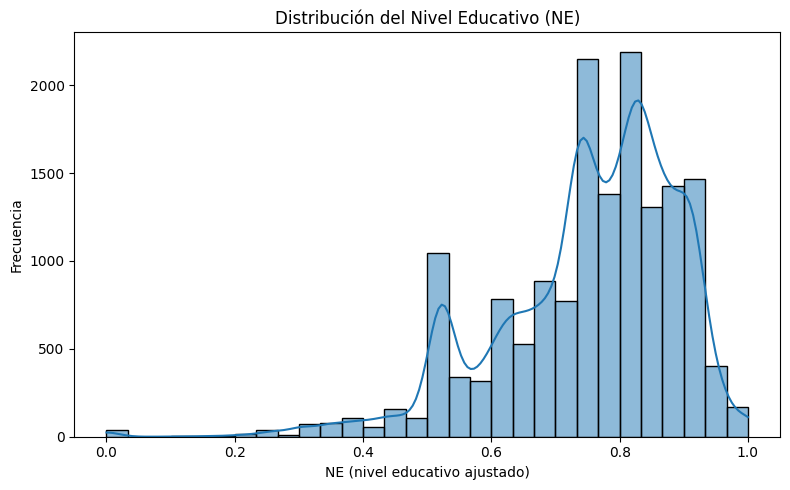

/tmp/ipython-input-3696691908.py:80: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Aglomerado", bbox_to_anchor=(1.05, 1), loc='upper left')


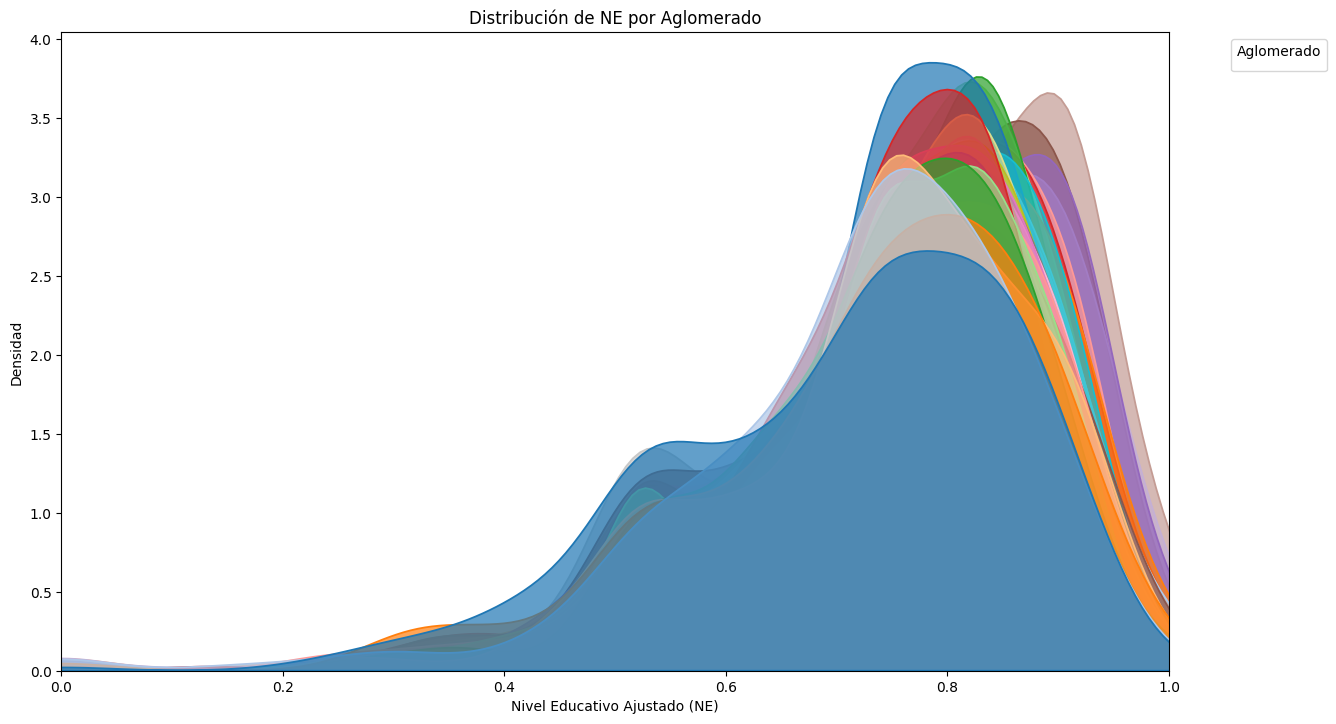

/tmp/ipython-input-3696691908.py:127: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Región", bbox_to_anchor=(1.05, 1), loc='upper left')


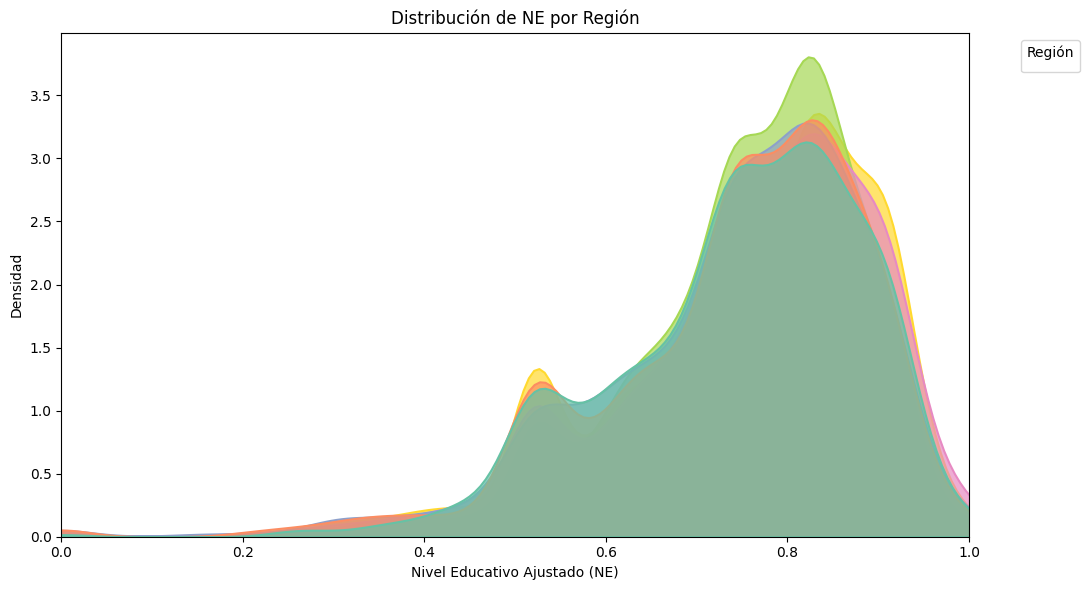

In [9]:
# ============================================================
# Estadística descriptiva general del dataset df_modelo
# ============================================================

# ------------------------------------------------------------
# Estadísticas básicas
# ------------------------------------------------------------
variables_interes = [
    'HAC', 'INDICE_CARGA_COMPARTIDA',
    'EDA', 'FEM', 'ANALFABET', 'DESOCUP', 'INACTIVOS', 'NE'
]

desc_stats = df_modelo[variables_interes].describe().T
desc_stats['missing'] = df_modelo[variables_interes].isnull().sum()
desc_stats['missing_pct'] = 100 * desc_stats['missing'] / len(df_modelo)

# Mostrar resumen estadístico
display(desc_stats.round(2))

# ------------------------------------------------------------
# Distribución del NE (Nivel educativo ajustado)
# ------------------------------------------------------------
plt.figure(figsize=(8, 5))
sns.histplot(df_modelo['NE'], bins=30, kde=True)
plt.title('Distribución del Nivel Educativo (NE)')
plt.xlabel('NE (nivel educativo ajustado)')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# Distribución de NE por aglomerado
# ------------------------------------------------------------
if 'AGLOMERADO' in df_modelo.columns:

    aglomerado_nombres = {
        2:  "Gran La Plata", 3:  "Bahía Blanca - Cerri", 4:  "Gran Rosario",
        5:  "Gran Santa Fe", 6:  "Gran Paraná", 7:  "Posadas", 8:  "Gran Resistencia",
        9:  "Comodoro Rivadavia - Rada Tilly", 10: "Gran Mendoza", 12: "Corrientes",
        13: "Gran Córdoba", 14: "Concordia", 15: "Formosa", 17: "Neuquén - Plottier",
        18: "Santiago del Estero - La Banda", 19: "Jujuy - Palpalá", 20: "Río Gallegos",
        22: "Gran Catamarca", 23: "Gran Salta", 25: "La Rioja", 26: "Gran San Luis",
        27: "Gran San Juan", 29: "Gran Tucumán - Tafí Viejo", 30: "Santa Rosa - Toay",
        31: "Ushuaia - Río Grande", 32: "Ciudad Autónoma de Buenos Aires",
        33: "Partidos del GBA", 34: "Mar del Plata", 36: "Río Cuarto",
        38: "San Nicolás - Villa Constitución", 91: "Rawson - Trelew",
        93: "Viedma - Carmen de Patagones"
    }

    df_modelo['AGLOMERADO_NOMBRE'] = df_modelo['AGLOMERADO'].map(aglomerado_nombres)
    df_plot_aglo = df_modelo.dropna(subset=['AGLOMERADO_NOMBRE'])

    top_aglos = (
        df_plot_aglo['AGLOMERADO_NOMBRE']
        .value_counts()
        .loc[lambda x: x >= 100]
        .index.tolist()
    )
    df_plot_aglo = df_plot_aglo[df_plot_aglo['AGLOMERADO_NOMBRE'].isin(top_aglos)]

    orden_aglo = df_plot_aglo.groupby('AGLOMERADO_NOMBRE')['NE'].median().sort_values().index

    plt.figure(figsize=(12, 8))
    sns.kdeplot(
        data=df_plot_aglo,
        x='NE',
        hue='AGLOMERADO_NOMBRE',
        common_norm=False,
        fill=True,
        linewidth=1.3,
        alpha=0.7,
        palette='tab20',
        hue_order=orden_aglo
    )
    plt.title("Distribución de NE por Aglomerado")
    plt.xlabel("Nivel Educativo Ajustado (NE)")
    plt.ylabel("Densidad")
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.legend(title="Aglomerado", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

else:
    print("La variable AGLOMERADO no está presente en df_modelo.")

# ------------------------------------------------------------
# Distribución de NE por región
# ------------------------------------------------------------
if 'REGION' in df_modelo.columns:

    region_nombres = {
        1:  "Gran Buenos Aires",
        40: "Noroeste",
        41: "Noreste",
        42: "Cuyo",
        43: "Pampeana",
        44: "Patagonia"
    }

    df_modelo['REGION_NOMBRE'] = df_modelo['REGION'].map(region_nombres)
    df_plot_region = df_modelo.dropna(subset=['REGION_NOMBRE'])

    if df_plot_region['REGION_NOMBRE'].nunique() > 1:

        orden_region = (
            df_plot_region.groupby('REGION_NOMBRE')['NE']
            .median().sort_values().index
        )

        plt.figure(figsize=(10, 6))
        sns.kdeplot(
            data=df_plot_region,
            x='NE',
            hue='REGION_NOMBRE',
            hue_order=orden_region,
            fill=True,
            common_norm=False,
            alpha=0.7,
            linewidth=1.5,
            palette='Set2'
        )
        plt.title("Distribución de NE por Región")
        plt.xlabel("Nivel Educativo Ajustado (NE)")
        plt.ylabel("Densidad")
        plt.xlim(0, 1)
        plt.tight_layout()
        plt.legend(title="Región", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()

    else:
        print("No hay suficientes regiones válidas para comparar.")

else:
    print("La variable REGION no está presente en df_modelo.")

,mean,std,coef_var,skew,kurtosis,missing,missing_pct
HAC,1.62,0.80,0.49,2.02,7.10,0,0.0
INDICE_CARGA_COMPARTIDA,0.68,0.34,0.50,0.35,0.31,0,0.0
EDA,42.11,18.95,0.45,0.59,-0.68,0,0.0
FEM,0.52,0.30,0.58,-0.01,-0.64,0,0.0
ANALFABET,0.04,0.11,2.89,3.71,18.13,0,0.0
DESOCUP,0.02,0.09,4.61,5.97,43.87,0,0.0
INACTIVOS,0.42,0.36,0.86,0.35,-1.12,0,0.0
NE,0.75,0.14,0.19,-1.14,1.99,0,0.0


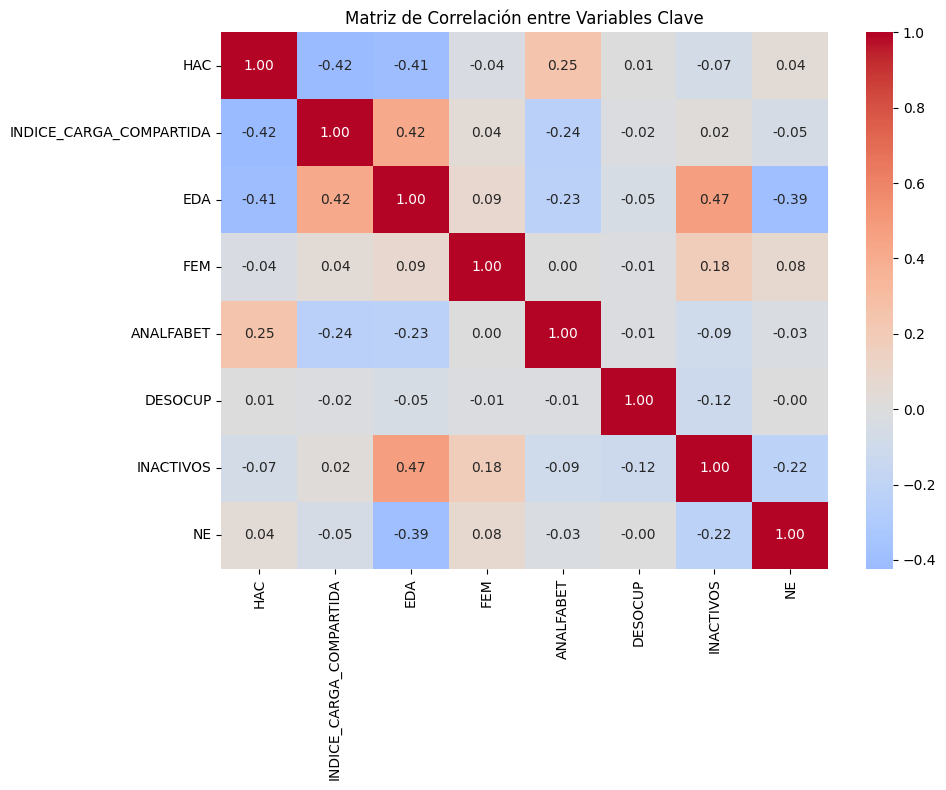

In [10]:
# ------------------------------------------------------------
# Estadísticas complementarias: CV, skewness, kurtosis
# ------------------------------------------------------------
desc_stats['coef_var'] = desc_stats['std'] / desc_stats['mean']
desc_stats['skew'] = df_modelo[variables_interes].skew()
desc_stats['kurtosis'] = df_modelo[variables_interes].kurtosis()

# Mostrar estadísticas ampliadas
display(
    desc_stats[['mean', 'std', 'coef_var', 'skew', 'kurtosis', 'missing', 'missing_pct']].round(2)
)

# ------------------------------------------------------------
# Correlación entre variables clave
# ------------------------------------------------------------
plt.figure(figsize=(10, 8))
sns.heatmap(df_modelo[variables_interes].corr(), annot=True, fmt='.2f',
            cmap='coolwarm', center=0)
plt.title("Matriz de Correlación entre Variables Clave")
plt.tight_layout()
plt.show()


##5. Regresion
$${NE}_i = f(X_i) + \varepsilon_i$$

###5.1 MCO con seleccion de variables

In [11]:
# ============================================================
# Regresión lineal con selección de variables (NE como dependiente)
# ============================================================

# ------------------------------------------------------------
# Preparación de variables X (predictoras) e y (respuesta)
# ------------------------------------------------------------
columnas_excluidas = [
    'NE', 'PONDERA', 'PONDIH',
    'EDA_sum', 'FEM_sum', 'ANALFABET_sum',
    'DESOCUP_sum', 'INACTIVOS_sum', 'IEAE_sum',
    'VII1_1', 'VII1_2', 'VII2_1', 'VII2_2', 'VII2_3', 'VII2_4'
]

X = df_modelo.drop(columns=columnas_excluidas, errors='ignore')
y = df_modelo['NE']

# Transformar variables categóricas a dummies
categoricas = ['REGION', 'AGLOMERADO']
X = pd.get_dummies(X, columns=[c for c in categoricas if c in X.columns], drop_first=True)

# Seleccionar solo columnas numéricas
X = X.select_dtypes(include=[np.number])

# ------------------------------------------------------------
# División en conjuntos de entrenamiento y prueba
# ------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0
)

# ------------------------------------------------------------
# Definición de modelos (con imputación + estandarización)
# ------------------------------------------------------------
modelos = {
    'Lasso': make_pipeline(
        SimpleImputer(strategy='mean'),
        StandardScaler(),
        LassoCV(cv=5, random_state=0)
    ),
    'Ridge': make_pipeline(
        SimpleImputer(strategy='mean'),
        StandardScaler(),
        RidgeCV(cv=5)
    ),
    'ElasticNet': make_pipeline(
        SimpleImputer(strategy='mean'),
        StandardScaler(),
        ElasticNetCV(cv=5, random_state=0)
    )
}

# ------------------------------------------------------------
# Entrenamiento, predicción y evaluación
# ------------------------------------------------------------
resultados = []

for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    resultados.append({
        'Modelo': nombre,
        'R2': r2_score(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred))
    })

# ------------------------------------------------------------
# Resultados finales
# ------------------------------------------------------------
df_resultados = pd.DataFrame(resultados)
print(df_resultados)

       Modelo        R2      RMSE
0       Lasso  0.331299  0.118246
1       Ridge  0.331770  0.118205
2  ElasticNet  0.331281  0.118248


###5.2 Bosques aleatorios

In [12]:
# ============================================================
# Random Forest Regressor (predicción de NE)
# ============================================================

# ------------------------------------------------------------
# Preparación de datos (X e y)
# ------------------------------------------------------------
columnas_excluidas = [
    'NE', 'PONDERA', 'PONDIH',
    'EDA_sum', 'FEM_sum', 'ANALFABET_sum',
    'DESOCUP_sum', 'INACTIVOS_sum', 'IEAE_sum',
    'VII1_1', 'VII1_2', 'VII2_1', 'VII2_2', 'VII2_3', 'VII2_4'
]

X = df_modelo.drop(columns=columnas_excluidas, errors='ignore')
y = df_modelo['NE']

# Variables categóricas a dummies
categoricas = ['REGION', 'AGLOMERADO']
X = pd.get_dummies(X, columns=[c for c in categoricas if c in X.columns], drop_first=True)

# Seleccionar solo variables numéricas
X = X.select_dtypes(include=[np.number])

# División entrenamiento / prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0
)

# ------------------------------------------------------------
# Entrenamiento del modelo Random Forest
# ------------------------------------------------------------
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=0
)

rf_model.fit(X_train, y_train)

# ------------------------------------------------------------
# Predicción y evaluación
# ------------------------------------------------------------
y_pred_rf = rf_model.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

# ------------------------------------------------------------
# Actualización y visualización de resultados
# ------------------------------------------------------------
df_resultados = pd.concat([
    df_resultados,
    pd.DataFrame([{'Modelo': 'RandomForest', 'R2': r2_rf, 'RMSE': rmse_rf}])
], ignore_index=True)

print("\nResultados incluyendo Random Forest:")
print(df_resultados)


Resultados incluyendo Random Forest:
         Modelo        R2      RMSE
0         Lasso  0.331299  0.118246
1         Ridge  0.331770  0.118205
2    ElasticNet  0.331281  0.118248
3  RandomForest  0.419851  0.110139



Análisis de importancia de variables con SHAP (Random Forest - versión rápida):


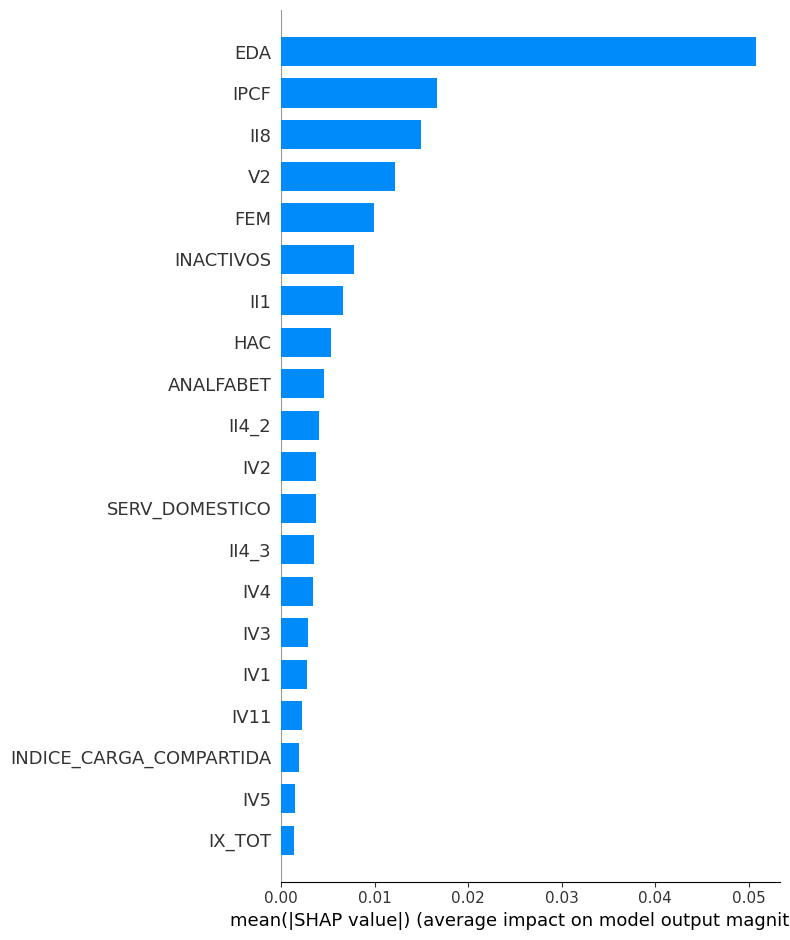

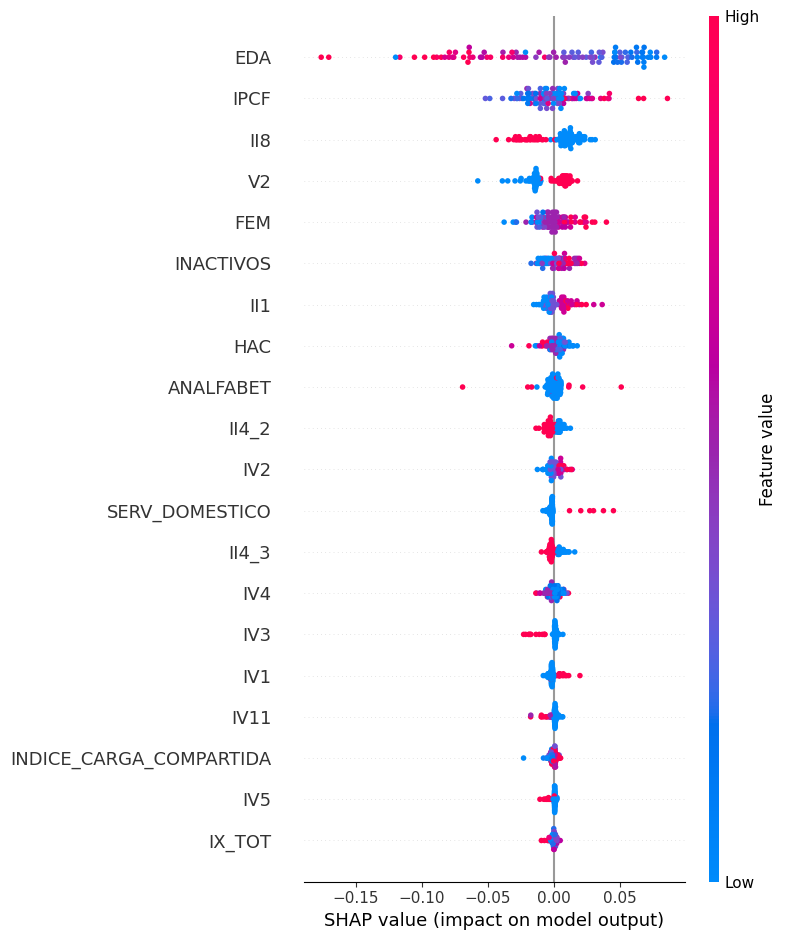

In [13]:
# ------------------------------------------------------------
# Análisis de importancia de variables con SHAP (versión rápida)
# ------------------------------------------------------------
print("\nAnálisis de importancia de variables con SHAP (Random Forest - versión rápida):")

# Crear el explainer
explainer = shap.TreeExplainer(rf_model)

# Tomar una muestra representativa para análisis SHAP
X_sample = X_train.sample(n=100, random_state=0)

# Calcular los valores SHAP solo para esa muestra
shap_values = explainer.shap_values(X_sample)

# Gráfico de resumen: importancia media absoluta de cada variable
shap.summary_plot(shap_values, X_sample, plot_type="bar")

# Gráfico detallado: dispersión y dirección del efecto
shap.summary_plot(shap_values, X_sample)

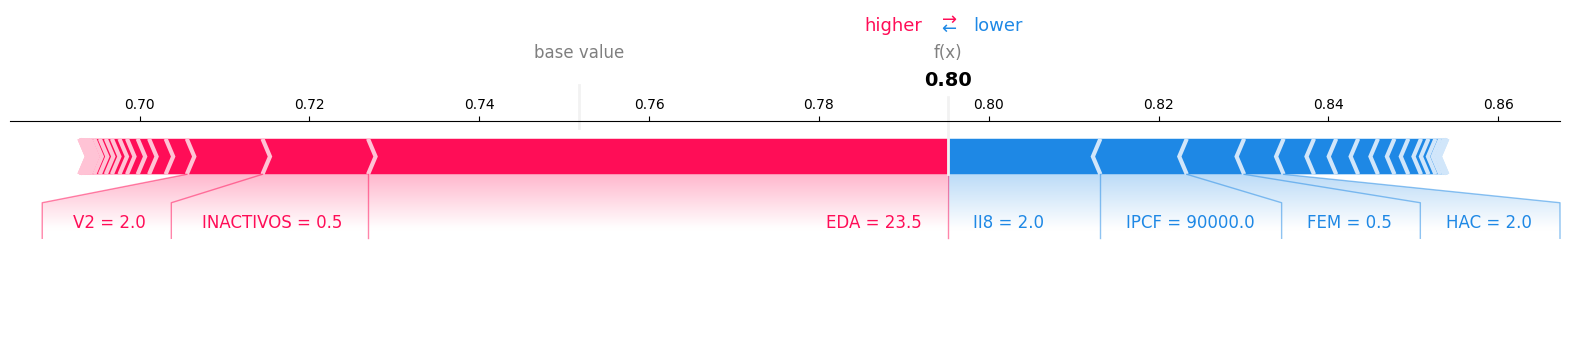

In [14]:
# Mostrar contribuciones para una observación específica
i = 0  # Cambiar el índice según el hogar de interés
shap.force_plot(explainer.expected_value, shap_values[i], X_sample.iloc[i], matplotlib=True)


Top 15 variables más importantes según SHAP (NE):
          Variable  SHAP_Importance
38             EDA         0.050786
1             IPCF         0.016663
23             II8         0.014995
26              V2         0.012133
39             FEM         0.009950
42       INACTIVOS         0.007821
16             II1         0.006670
33             HAC         0.005310
40       ANALFABET         0.004584
20           II4_2         0.004020
3              IV2         0.003726
35  SERV_DOMESTICO         0.003721
21           II4_3         0.003494
5              IV4         0.003451
4              IV3         0.002900


<Figure size 1000x600 with 0 Axes>

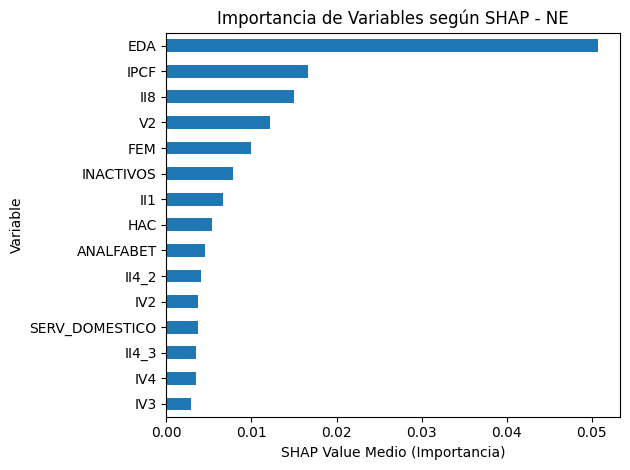

In [15]:
# ------------------------------------------------------------
# Importancia promedio por SHAP values (top 15)
# ------------------------------------------------------------
shap_importance = pd.DataFrame({
    'Variable': X_train.columns,
    'SHAP_Importance': np.abs(shap_values).mean(axis=0)
}).sort_values(by='SHAP_Importance', ascending=False)

print("\nTop 15 variables más importantes según SHAP (NE):")
print(shap_importance.head(15))

# Visualización
plt.figure(figsize=(10, 6))
shap_importance.head(15).set_index('Variable').plot(kind='barh', legend=False)
plt.title("Importancia de Variables según SHAP - NE")
plt.xlabel("SHAP Value Medio (Importancia)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

###5.3 Support Vector Regressor (SVR)

In [16]:
# ============================================================
# Support Vector Regressor (SVR) para predicción de NE
# ============================================================

# ------------------------------------------------------------
# Definición del modelo (pipeline con estandarización)
# ------------------------------------------------------------
svr_model = make_pipeline(
    StandardScaler(),
    SVR(kernel='rbf', C=1.0, epsilon=0.1)
)

# ------------------------------------------------------------
# Entrenamiento del modelo
# ------------------------------------------------------------
svr_model.fit(X_train, y_train)

# ------------------------------------------------------------
# Predicción y evaluación
# ------------------------------------------------------------
y_pred_svr = svr_model.predict(X_test)

r2_svr = r2_score(y_test, y_pred_svr)
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))

# ------------------------------------------------------------
# Actualización de tabla de resultados
# ------------------------------------------------------------
df_resultados = pd.concat([
    df_resultados,
    pd.DataFrame([{'Modelo': 'SVR', 'R2': r2_svr, 'RMSE': rmse_svr}])
], ignore_index=True)

print("\nResultados incluyendo SVR:")
print(df_resultados)


Resultados incluyendo SVR:
         Modelo        R2      RMSE
0         Lasso  0.331299  0.118246
1         Ridge  0.331770  0.118205
2    ElasticNet  0.331281  0.118248
3  RandomForest  0.419851  0.110139
4           SVR  0.345829  0.116955


###5.4 XGBoost

In [17]:
# ============================================================
# XGBoost Regressor
# ============================================================
xgb_model = make_pipeline(
    SimpleImputer(strategy='mean'),
    XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=0)
)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

r2_xgb = r2_score(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

df_resultados = pd.concat([
    df_resultados,
    pd.DataFrame([{'Modelo': 'XGBoost', 'R2': r2_xgb, 'RMSE': rmse_xgb}])
], ignore_index=True)

# ============================================================
# KNN Regressor
# ============================================================
knn_model = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    KNeighborsRegressor(n_neighbors=5)
)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

r2_knn = r2_score(y_test, y_pred_knn)
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))

df_resultados = pd.concat([
    df_resultados,
    pd.DataFrame([{'Modelo': 'KNN', 'R2': r2_knn, 'RMSE': rmse_knn}])
], ignore_index=True)

print("\nResultados incluyendo XGBoost y KNN:")
print(df_resultados)


Resultados incluyendo XGBoost y KNN:
         Modelo        R2      RMSE
0         Lasso  0.331299  0.118246
1         Ridge  0.331770  0.118205
2    ElasticNet  0.331281  0.118248
3  RandomForest  0.419851  0.110139
4           SVR  0.345829  0.116955
5       XGBoost  0.443181  0.107902
6           KNN  0.229514  0.126927


##6. Clasificacion
$${PE}_i = \mathbb{I}({NE}_i<\tau)$$

$\tau$: Mediana

###6.1 Regresión Logística

In [18]:
# ============================================================
# Clasificación: Regresión Logística (Logit)
# ============================================================

# ------------------------------------------------------------
# Crear variable binaria PE (por debajo de la mediana de NE)
# ------------------------------------------------------------
tau = df_modelo['NE'].median()
df_modelo['PE'] = (df_modelo['NE'] < tau).astype(int)

# ------------------------------------------------------------
# Preparación de datos (X e y)
# ------------------------------------------------------------
columnas_excluidas_clasif = [
    'NE', 'PE', 'PONDERA', 'PONDIH',
    'EDA_sum', 'FEM_sum', 'ANALFABET_sum',
    'DESOCUP_sum', 'INACTIVOS_sum', 'IEAE_sum',
]


X = df_modelo.drop(columns=columnas_excluidas_clasif, errors='ignore')
y = df_modelo['PE']

# Variables categóricas a dummies
categoricas = ['REGION', 'AGLOMERADO']
X = pd.get_dummies(X, columns=[c for c in categoricas if c in X.columns], drop_first=True)

# Asegurar que todas las columnas sean numéricas
X = X.select_dtypes(include=[np.number])

# ------------------------------------------------------------
# División en entrenamiento y prueba
# ------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0
)

# ------------------------------------------------------------
# Entrenamiento del modelo Logit (Regresión Logística)
# ------------------------------------------------------------
logit_model = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    LogisticRegression(max_iter=1000, random_state=0)
)

logit_model.fit(X_train, y_train)
y_pred_logit = logit_model.predict(X_test)

# ------------------------------------------------------------
# Evaluación del modelo
# ------------------------------------------------------------
accuracy_logit = accuracy_score(y_test, y_pred_logit)
conf_mat_logit = confusion_matrix(y_test, y_pred_logit)
report_logit = classification_report(y_test, y_pred_logit)

print("\nResultados del modelo Logit (Regresión Logística):")
print(f"Exactitud (Accuracy): {accuracy_logit:.4f}")
print("\nMatriz de Confusión:")
print(conf_mat_logit)
print("\nReporte de Clasificación:")
print(report_logit)

# Extraer coeficientes del modelo logístico
modelo_logit = logit_model.named_steps['logisticregression']
coefs = pd.Series(modelo_logit.coef_[0], index=X.columns)

# Mostrar los 10 más importantes
print("\nTop 10 coeficientes (positivos y negativos):")
print(coefs.sort_values(key=abs, ascending=False).head(10))


Resultados del modelo Logit (Regresión Logística):
Exactitud (Accuracy): 0.7053

Matriz de Confusión:
[[1393  553]
 [ 614 1400]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.69      0.72      0.70      1946
           1       0.72      0.70      0.71      2014

    accuracy                           0.71      3960
   macro avg       0.71      0.71      0.71      3960
weighted avg       0.71      0.71      0.71      3960


Top 10 coeficientes (positivos y negativos):
EDA                0.946697
INACTIVOS         -0.403832
V2                -0.382024
SERV_DOMESTICO    -0.359905
PERSONAS_TAREAS    0.297937
IPCF              -0.297097
FEM               -0.292265
IX_TOT             0.284962
IV2               -0.269022
II8                0.225132
dtype: float64


###6.2 Bosques aleatorios

In [19]:
# ============================================================
# Clasificación: Random Forest Classifier con GridSearchCV
# ============================================================

# ------------------------------------------------------------
# Preparación de datos (X e y)
# ------------------------------------------------------------
columnas_excluidas_clasif = [
    'NE', 'PE', 'PONDERA', 'PONDIH',
    'EDA_sum', 'FEM_sum', 'ANALFABET_sum',
    'DESOCUP_sum', 'INACTIVOS_sum', 'IEAE_sum',
]


X = df_modelo.drop(columns=columnas_excluidas_clasif, errors='ignore')
y = df_modelo['PE']

# Variables categóricas a dummies
categoricas = ['REGION', 'AGLOMERADO']
X = pd.get_dummies(X, columns=[c for c in categoricas if c in X.columns], drop_first=True)

# Asegurar solo variables numéricas
X = X.select_dtypes(include=[np.number])

# ------------------------------------------------------------
# División entrenamiento / prueba
# ------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=0
)

# ------------------------------------------------------------
# Definición de hiperparámetros y GridSearchCV
# ------------------------------------------------------------
param_grid = {
    'n_estimators': [100],
    'max_depth': [10, 20],
    'min_samples_split': [2],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}

rf_clf_base = RandomForestClassifier(random_state=0)

grid_search = GridSearchCV(
    estimator=rf_clf_base,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# ------------------------------------------------------------
# Ajuste del modelo con búsqueda de grilla
# ------------------------------------------------------------
grid_search.fit(X_train, y_train)
best_rf_clf = grid_search.best_estimator_

# ------------------------------------------------------------
# Evaluación del mejor modelo
# ------------------------------------------------------------
y_pred_best = best_rf_clf.predict(X_test)

accuracy_best = accuracy_score(y_test, y_pred_best)
conf_mat_best = confusion_matrix(y_test, y_pred_best)
report_best = classification_report(y_test, y_pred_best)

print("\nMejores hiperparámetros encontrados:")
print(grid_search.best_params_)
print(f"\nExactitud (Accuracy): {accuracy_best:.4f}")
print("\nMatriz de Confusión:")
print(conf_mat_best)
print("\nReporte de Clasificación:")
print(report_best)

Fitting 5 folds for each of 4 candidates, totalling 20 fits

Mejores hiperparámetros encontrados:
{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}

Exactitud (Accuracy): 0.7245

Matriz de Confusión:
[[1426  520]
 [ 571 1443]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.71      0.73      0.72      1946
           1       0.74      0.72      0.73      2014

    accuracy                           0.72      3960
   macro avg       0.72      0.72      0.72      3960
weighted avg       0.72      0.72      0.72      3960




Análisis de importancia de variables con SHAP (Random Forest Classifier - PE):
Shape de shap_values_class1: (100, 49, 2)
Shape de X_sample_clf: (100, 49)


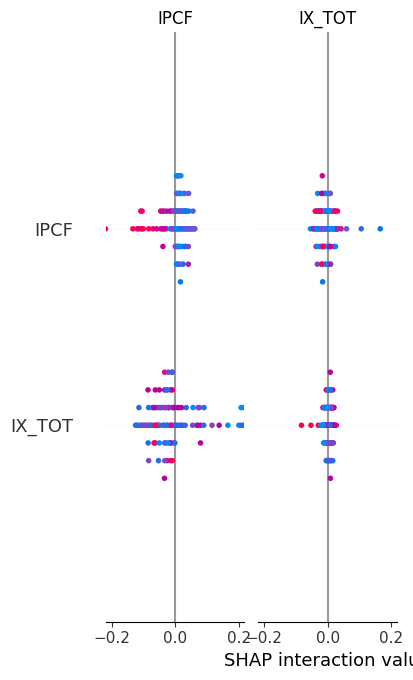

In [20]:
# ------------------------------------------------------------
# Análisis de importancia de variables con SHAP (clasificación PE)
# ------------------------------------------------------------
print("\nAnálisis de importancia de variables con SHAP (Random Forest Classifier - PE):")

# Crear explainer con TreeExplainer
explainer_clf = shap.TreeExplainer(best_rf_clf)

# Muestra para acelerar (asegurando que tenga las mismas columnas que X_train)
X_sample_clf = X_train.sample(n=min(100, len(X_train)), random_state=0)

# Obtener valores SHAP (devuelve una lista por clase)
shap_values_clf = explainer_clf.shap_values(X_sample_clf)

# Verificar estructura de shap_values_clf
if isinstance(shap_values_clf, list):
    print(f"Número de clases: {len(shap_values_clf)}")
    shap_values_class1 = shap_values_clf[1]  # Asume clase PE=1
else:
    shap_values_class1 = shap_values_clf  # Caso para explainers sin lista por clase

# Verificar shapes
print(f"Shape de shap_values_class1: {shap_values_class1.shape}")
print(f"Shape de X_sample_clf: {X_sample_clf.shape}")

# Gráfico de resumen tradicional (solo si shapes coinciden)
if shap_values_class1.shape[1] == X_sample_clf.shape[1]:
    shap.summary_plot(shap_values_class1, X_sample_clf)
else:
    print("¡Error! Shapes no coinciden. Revisa las transformaciones de los datos.")


Top 15 variables más importantes según Permutation Importance (clasificación PE):
          Variable  Importancia
44             EDA     0.111995
1             IPCF     0.023889
26              V2     0.017298
45             FEM     0.014419
48       INACTIVOS     0.013965
46       ANALFABET     0.007904
23             II8     0.006237
3              IV2     0.005606
41  SERV_DOMESTICO     0.004545
39             HAC     0.004394
16             II1     0.004141
12            IV11     0.003409
22             II7     0.003308
21           II4_3     0.003131
0           IX_TOT     0.002096


<Figure size 1000x600 with 0 Axes>

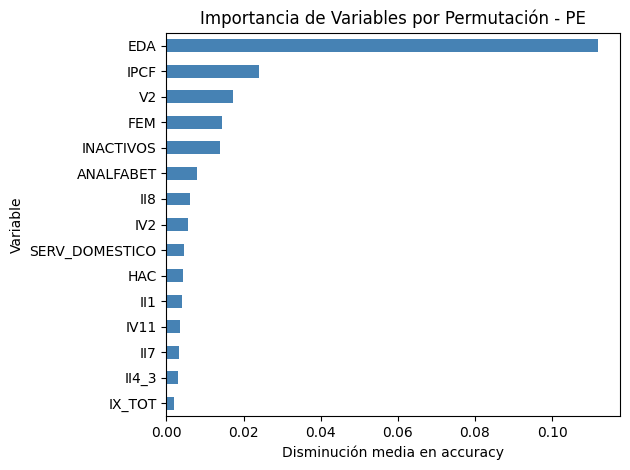

In [21]:
# ------------------------------------------------------------
# Importancia de variables por Permutación (clasificación PE)
# ------------------------------------------------------------

# Calcular importancia por permutación sobre el set de prueba
result = permutation_importance(
    best_rf_clf, X_test, y_test,
    n_repeats=10,
    random_state=0,
    n_jobs=-1
)

# Crear DataFrame con resultados
perm_importance_df = pd.DataFrame({
    'Variable': X_test.columns,
    'Importancia': result.importances_mean
}).sort_values(by='Importancia', ascending=False)

# Mostrar top 15
print("\nTop 15 variables más importantes según Permutation Importance (clasificación PE):")
print(perm_importance_df.head(15))

# Gráfico
plt.figure(figsize=(10, 6))
perm_importance_df.head(15).set_index('Variable').plot(
    kind='barh', legend=False, color='steelblue'
)
plt.title("Importancia de Variables por Permutación - PE")
plt.xlabel("Disminución media en accuracy")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

###6.3 Support Vector Machine (SVM)

In [22]:
# ============================================================
# Clasificación: Support Vector Machine (SVM)
# ============================================================

# ------------------------------------------------------------
# Definición del modelo (pipeline con estandarización)
# ------------------------------------------------------------
svm_model = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', C=1.0, gamma='scale', random_state=0)
)

# ------------------------------------------------------------
# Entrenamiento del modelo
# ------------------------------------------------------------
svm_model.fit(X_train, y_train)

# ------------------------------------------------------------
# Predicción y evaluación
# ------------------------------------------------------------
y_pred_svm = svm_model.predict(X_test)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
conf_mat_svm = confusion_matrix(y_test, y_pred_svm)
report_svm = classification_report(y_test, y_pred_svm)

# ------------------------------------------------------------
# Resultados
# ------------------------------------------------------------
print(f"Exactitud (Accuracy) SVM: {accuracy_svm:.4f}")
print("\nMatriz de Confusión (SVM):")
print(conf_mat_svm)
print("\nReporte de Clasificación (SVM):")
print(report_svm)

Exactitud (Accuracy) SVM: 0.7038

Matriz de Confusión (SVM):
[[1400  546]
 [ 627 1387]]

Reporte de Clasificación (SVM):
              precision    recall  f1-score   support

           0       0.69      0.72      0.70      1946
           1       0.72      0.69      0.70      2014

    accuracy                           0.70      3960
   macro avg       0.70      0.70      0.70      3960
weighted avg       0.70      0.70      0.70      3960



###6.4 XGBoost Classifier

In [23]:
# ============================================================
# XGBoost Classifier
# ============================================================
xgb_clf = make_pipeline(
    SimpleImputer(strategy='mean'),
    XGBClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        eval_metric='logloss',
        random_state=0
    )
)
xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"Exactitud (Accuracy) XGBoost: {accuracy_xgb:.4f}")

# ============================================================
# KNN Classifier
# ============================================================
knn_clf = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler(),
    KNeighborsClassifier(n_neighbors=5)
)
knn_clf.fit(X_train, y_train)
y_pred_knn = knn_clf.predict(X_test)

accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Exactitud (Accuracy) KNN: {accuracy_knn:.4f}")

# ============================================================
# Tabla final de resultados de clasificación
# ============================================================
df_resultados_clasif = pd.DataFrame([
    {'Modelo': 'Logit', 'Accuracy': accuracy_logit},
    {'Modelo': 'Random Forest', 'Accuracy': accuracy_best},
    {'Modelo': 'SVM', 'Accuracy': accuracy_svm},
    {'Modelo': 'XGBoost', 'Accuracy': accuracy_xgb},
    {'Modelo': 'KNN', 'Accuracy': accuracy_knn}
])

print("\nTabla final de clasificación (incluye XGBoost y KNN):")
print(df_resultados_clasif.to_string(index=False))

Exactitud (Accuracy) XGBoost: 0.7263
Exactitud (Accuracy) KNN: 0.6528

Tabla final de clasificación (incluye XGBoost y KNN):
       Modelo  Accuracy
        Logit  0.705303
Random Forest  0.724495
          SVM  0.703788
      XGBoost  0.726263
          KNN  0.652778


In [24]:
# ============================================================
# Resultados consolidados
# ============================================================

# ------------------------------------------------------------
# REGRESIÓN (NE)
# ------------------------------------------------------------
print("\n=== Resultados de modelos de regresión (NE) ===")
print(df_resultados.sort_values(by='R2', ascending=False).to_string(index=False))

# ------------------------------------------------------------
# CLASIFICACIÓN (PE)
# ------------------------------------------------------------
print("\n=== Resultados de modelos de clasificación (PE) ===")
print(df_resultados_clasif.sort_values(by='Accuracy', ascending=False).to_string(index=False))

# ------------------------------------------------------------
# Importancia SHAP (NE)
# ------------------------------------------------------------
print("\n=== Top 15 variables más importantes según SHAP (NE) ===")
print(shap_importance.head(15).to_string(index=False))

# ------------------------------------------------------------
# Importancia por Permutación (PE)
# ------------------------------------------------------------
print("\n=== Top 15 variables más importantes según Permutation Importance (PE) ===")
print(perm_importance_df.head(15).to_string(index=False))

# ------------------------------------------------------------
# Coeficientes del modelo Logit (PE)
# ------------------------------------------------------------
print("\n=== Top 10 coeficientes más importantes (Regresión Logística - PE) ===")
top_coefs = coefs.sort_values(key=abs, ascending=False).head(10)
print(top_coefs.to_string())



=== Resultados de modelos de regresión (NE) ===
      Modelo       R2     RMSE
     XGBoost 0.443181 0.107902
RandomForest 0.419851 0.110139
         SVR 0.345829 0.116955
       Ridge 0.331770 0.118205
       Lasso 0.331299 0.118246
  ElasticNet 0.331281 0.118248
         KNN 0.229514 0.126927

=== Resultados de modelos de clasificación (PE) ===
       Modelo  Accuracy
      XGBoost  0.726263
Random Forest  0.724495
        Logit  0.705303
          SVM  0.703788
          KNN  0.652778

=== Top 15 variables más importantes según SHAP (NE) ===
      Variable  SHAP_Importance
           EDA         0.050786
          IPCF         0.016663
           II8         0.014995
            V2         0.012133
           FEM         0.009950
     INACTIVOS         0.007821
           II1         0.006670
           HAC         0.005310
     ANALFABET         0.004584
         II4_2         0.004020
           IV2         0.003726
SERV_DOMESTICO         0.003721
         II4_3         0.003494


##7. Interpretacion

/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:253: FutureWarning: In the future, passing feature_perturbation='interventional' without providing a background dataset will raise an error. Please provide a background dataset to continue using the interventional approach or set feature_perturbation='auto' to automatically switch approaches.
  warnings.warn(


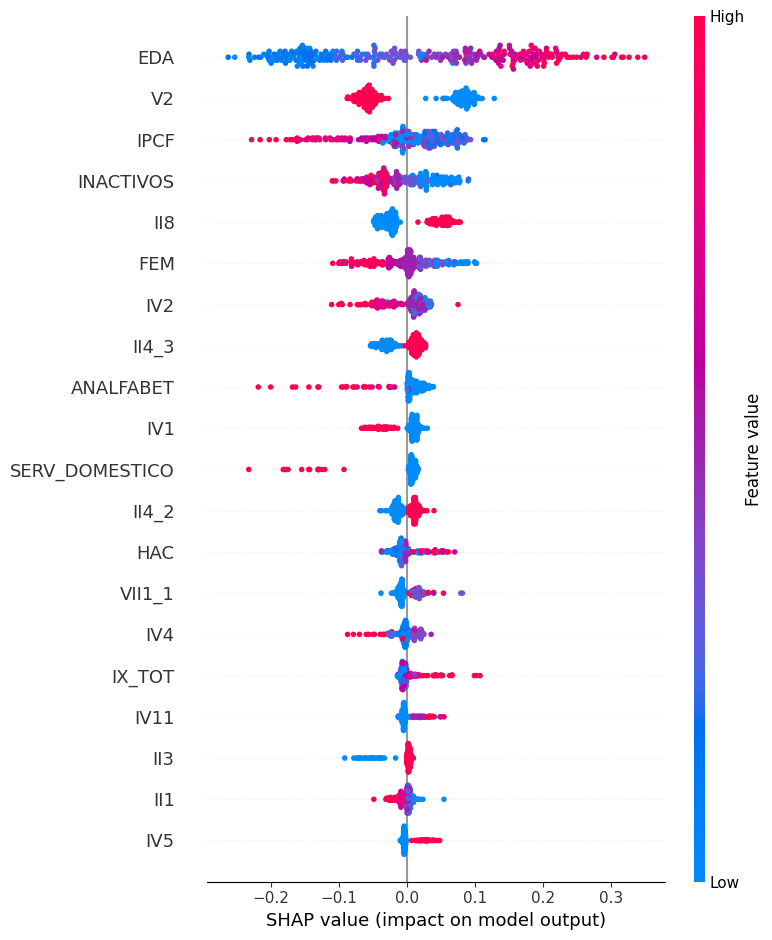

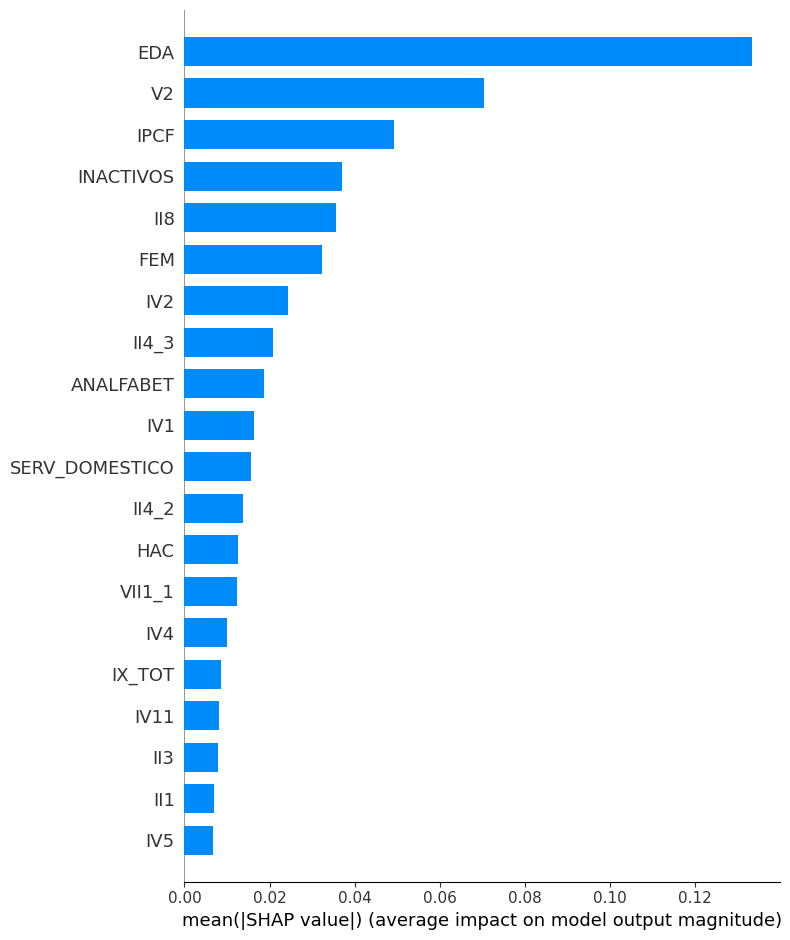


Top 10 variables más importantes según SHAP (NE):
- La variable **EDA** tuvo una contribución media de 0.1333 a la predicción del NE.
- La variable **V2** tuvo una contribución media de 0.0703 a la predicción del NE.
- La variable **IPCF** tuvo una contribución media de 0.0492 a la predicción del NE.
- La variable **INACTIVOS** tuvo una contribución media de 0.0370 a la predicción del NE.
- La variable **II8** tuvo una contribución media de 0.0356 a la predicción del NE.
- La variable **FEM** tuvo una contribución media de 0.0324 a la predicción del NE.
- La variable **IV2** tuvo una contribución media de 0.0244 a la predicción del NE.
- La variable **II4_3** tuvo una contribución media de 0.0207 a la predicción del NE.
- La variable **ANALFABET** tuvo una contribución media de 0.0187 a la predicción del NE.
- La variable **IV1** tuvo una contribución media de 0.0164 a la predicción del NE.


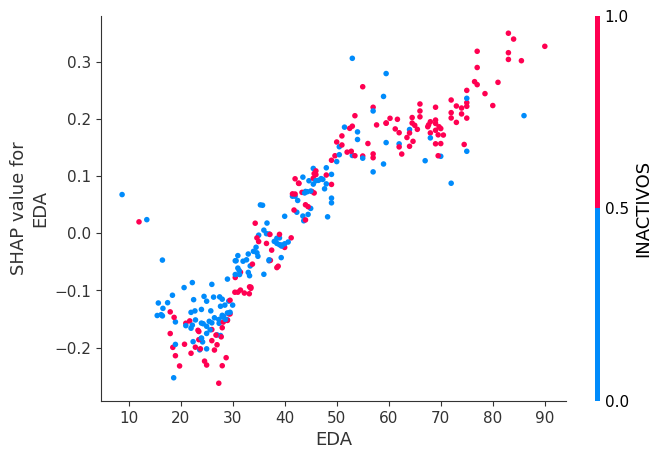

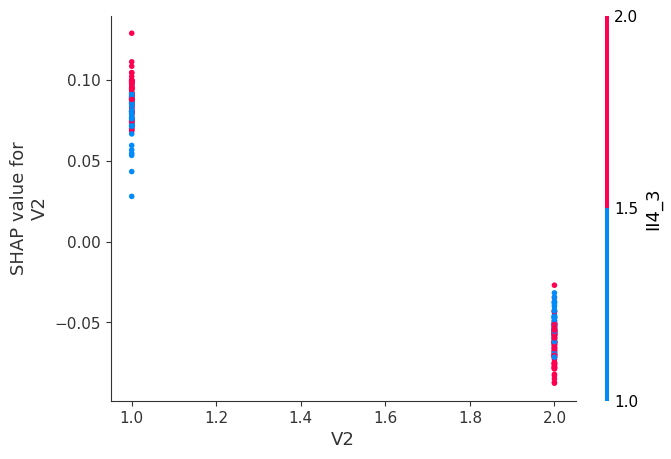

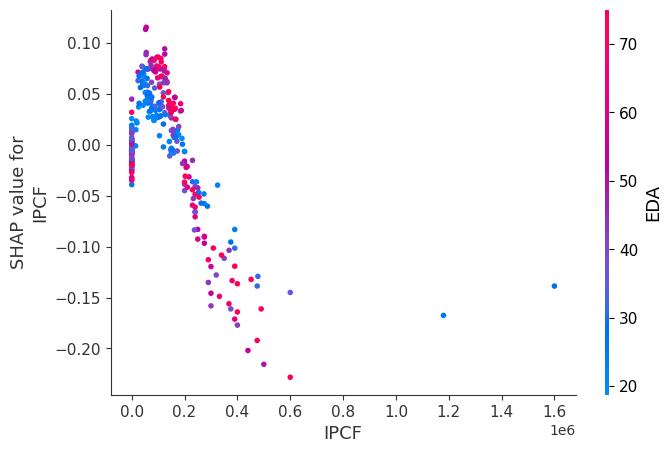

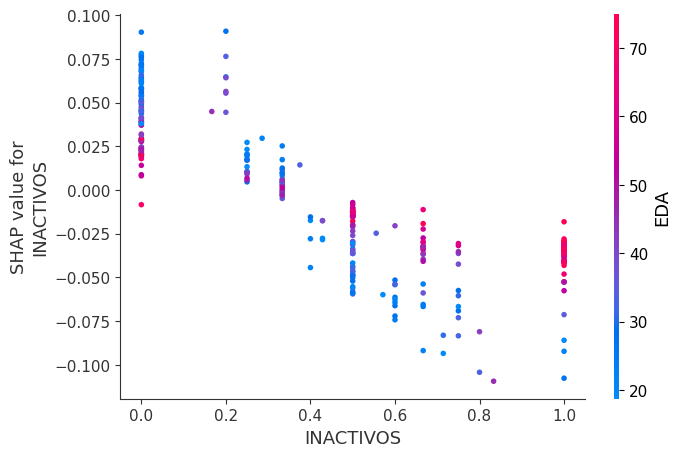

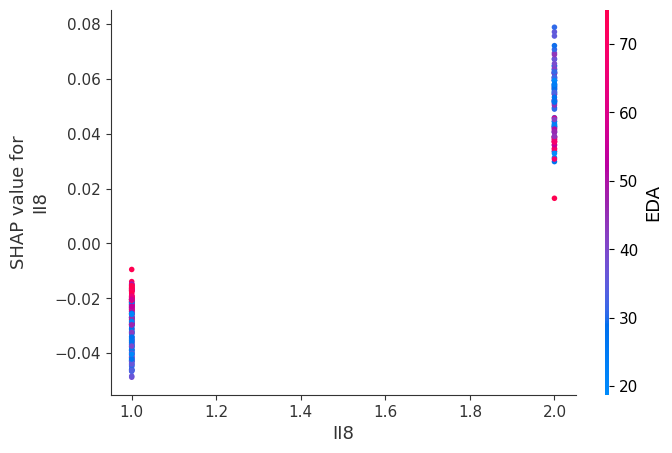

In [25]:
# ============================================================
# SHAP con modelo XGBoost entrenado directamente (sin pipeline)
# ============================================================

# ------------------------------------------------------------
# Entrenamiento del modelo fuera del pipeline (seguro para SHAP)
# ------------------------------------------------------------
xgb_reg_shap = XGBRegressor(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=0
)
xgb_reg_shap.fit(X_train, y_train)

# ------------------------------------------------------------
# Seleccionar muestra reducida para evitar crashes
# ------------------------------------------------------------
X_sample = X_train.sample(n=300, random_state=0)

# ------------------------------------------------------------
# Crear explainer seguro
# ------------------------------------------------------------
explainer = shap.TreeExplainer(
    xgb_reg_shap,
    feature_perturbation="interventional"
)

# ------------------------------------------------------------
# Calcular valores SHAP sin check de aditividad (previene crash)
# ------------------------------------------------------------
shap_values = explainer.shap_values(
    X_sample,
    check_additivity=False
)

# ------------------------------------------------------------
# Gráfico de resumen (dirección e intensidad del efecto)
# ------------------------------------------------------------
shap.summary_plot(shap_values, X_sample)

# ------------------------------------------------------------
# Gráfico tipo barra (importancia media absoluta)
# ------------------------------------------------------------
shap.summary_plot(shap_values, X_sample, plot_type="bar")

# ------------------------------------------------------------
# Importancia media de cada variable (SHAP)
# ------------------------------------------------------------
shap_importance = pd.DataFrame({
    'Variable': X_sample.columns,
    'SHAP_Importance': np.abs(shap_values).mean(axis=0)
}).sort_values(by='SHAP_Importance', ascending=False)

# ------------------------------------------------------------
# Narrativa automática: top 10 variables explicativas
# ------------------------------------------------------------
print("\nTop 10 variables más importantes según SHAP (NE):")
for i, row in shap_importance.head(10).iterrows():
    print(f"- La variable **{row['Variable']}** tuvo una contribución media de {row['SHAP_Importance']:.4f} a la predicción del NE.")

# ------------------------------------------------------------
# Gráficos de dependencia para las 5 variables principales
# ------------------------------------------------------------
top_vars = shap_importance['Variable'].head(5).tolist()
for var in top_vars:
    shap.dependence_plot(var, shap_values, X_sample)

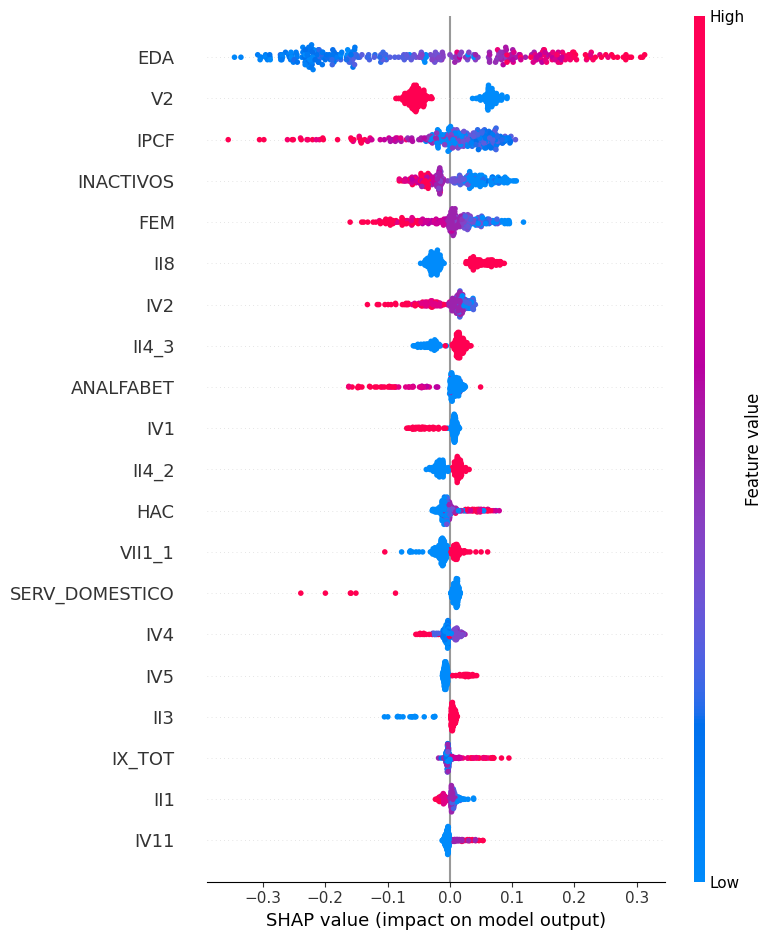

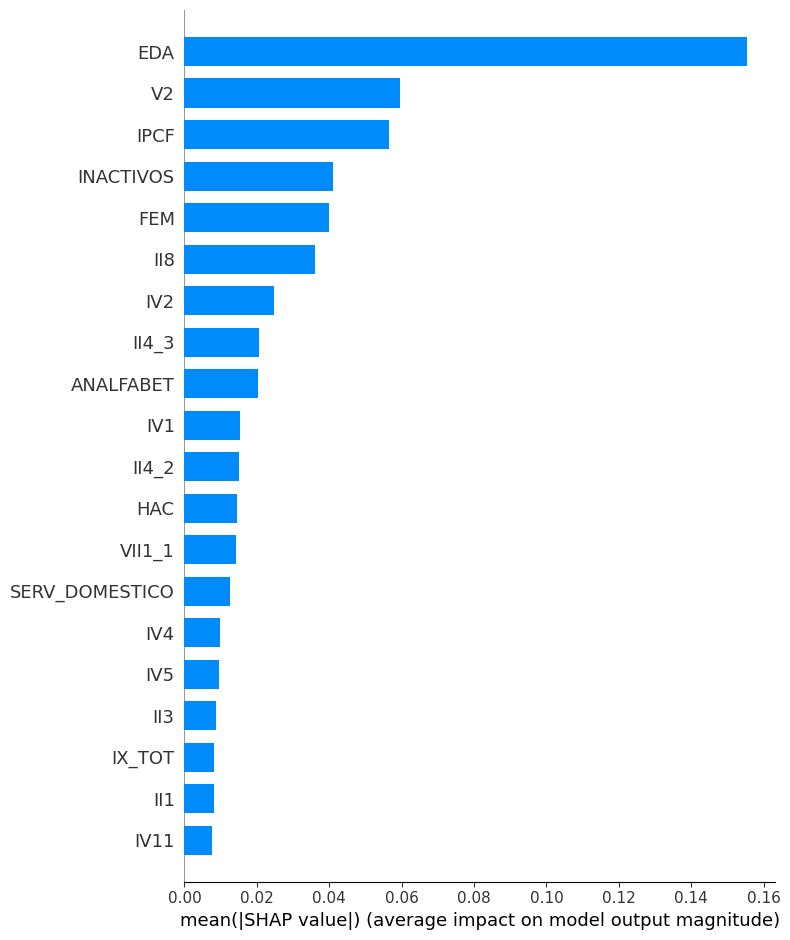


Top 10 variables más importantes según SHAP (clasificación PE):
- La variable **EDA** tuvo una contribución media de 0.1554 a la predicción de PE.
- La variable **V2** tuvo una contribución media de 0.0596 a la predicción de PE.
- La variable **IPCF** tuvo una contribución media de 0.0566 a la predicción de PE.
- La variable **INACTIVOS** tuvo una contribución media de 0.0409 a la predicción de PE.
- La variable **FEM** tuvo una contribución media de 0.0399 a la predicción de PE.
- La variable **II8** tuvo una contribución media de 0.0359 a la predicción de PE.
- La variable **IV2** tuvo una contribución media de 0.0247 a la predicción de PE.
- La variable **II4_3** tuvo una contribución media de 0.0205 a la predicción de PE.
- La variable **ANALFABET** tuvo una contribución media de 0.0202 a la predicción de PE.
- La variable **IV1** tuvo una contribución media de 0.0154 a la predicción de PE.


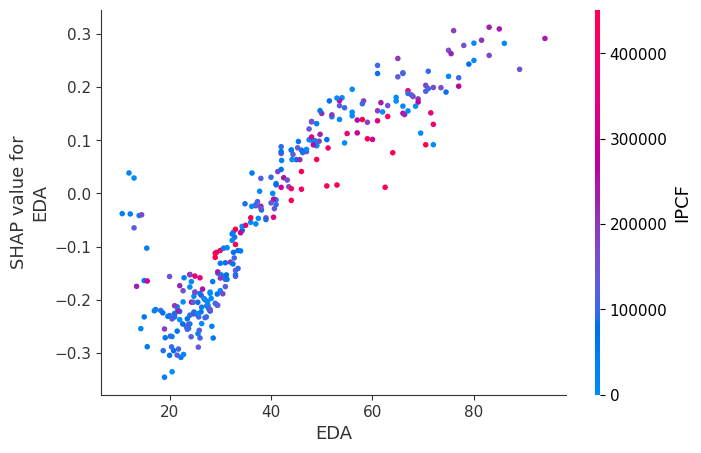

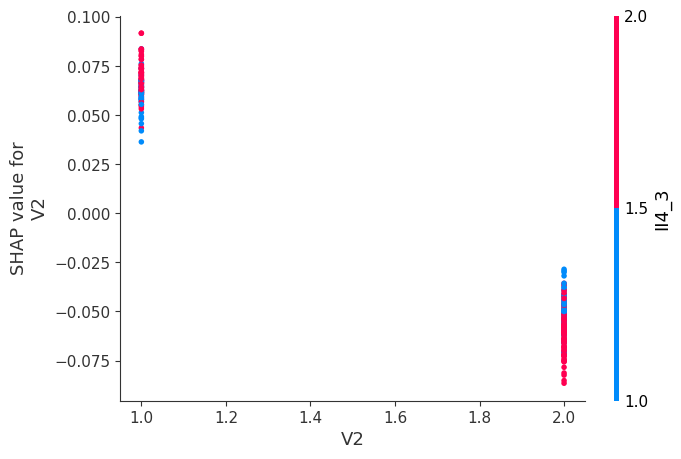

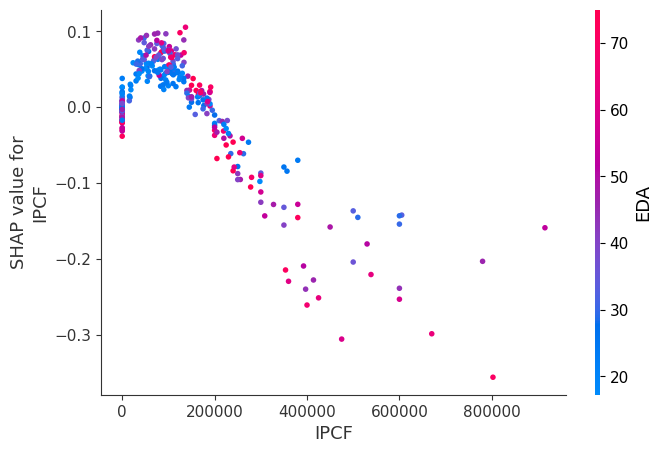

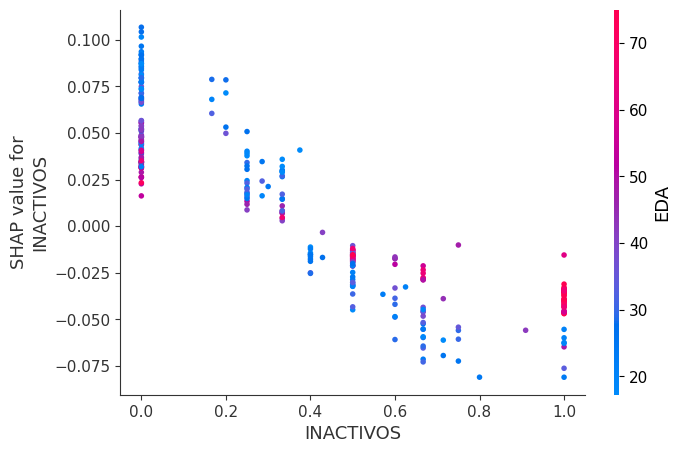

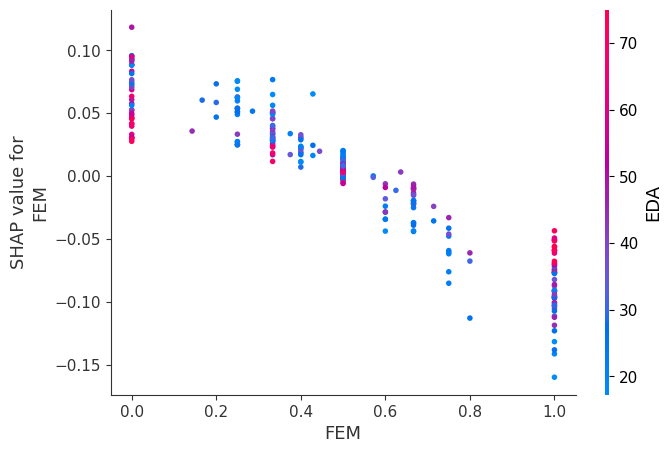

In [26]:
# ============================================================
# SHAP con modelo XGBoost Classifier (clasificación binaria - PE)
# ============================================================

# ------------------------------------------------------------
# Entrenamiento del modelo fuera del pipeline (seguro para SHAP)
# ------------------------------------------------------------
xgb_clf_shap = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    eval_metric='logloss',
    random_state=0
)
xgb_clf_shap.fit(X_train, y_train)

# ------------------------------------------------------------
# Crear dataset de fondo y muestra para SHAP
# ------------------------------------------------------------
X_background = X_train.sample(n=100, random_state=0)  # para explicar interacciones
X_sample_clf = X_train.sample(n=300, random_state=1)  # para generar gráficos

# ------------------------------------------------------------
# Crear explainer TreeExplainer seguro (con background)
# ------------------------------------------------------------
explainer_clf = shap.TreeExplainer(
    xgb_clf_shap,
    data=X_background,
    model_output="probability",
    feature_perturbation="interventional"
)

# ------------------------------------------------------------
# Calcular valores SHAP
# ------------------------------------------------------------
shap_values_clf = explainer_clf.shap_values(X_sample_clf)

# ------------------------------------------------------------
# Gráfico de resumen (efecto individual y dirección)
# ------------------------------------------------------------
shap.summary_plot(shap_values_clf, X_sample_clf)

# ------------------------------------------------------------
# Gráfico tipo barra (importancia media absoluta)
# ------------------------------------------------------------
shap.summary_plot(shap_values_clf, X_sample_clf, plot_type="bar")

# ------------------------------------------------------------
# Importancia media de cada variable (SHAP)
# ------------------------------------------------------------
shap_importance_clf = pd.DataFrame({
    'Variable': X_sample_clf.columns,
    'SHAP_Importance': np.abs(shap_values_clf).mean(axis=0)
}).sort_values(by='SHAP_Importance', ascending=False)

# ------------------------------------------------------------
# Narrativa automática: top 10 variables explicativas
# ------------------------------------------------------------
print("\nTop 10 variables más importantes según SHAP (clasificación PE):")
for i, row in shap_importance_clf.head(10).iterrows():
    print(f"- La variable **{row['Variable']}** tuvo una contribución media de {row['SHAP_Importance']:.4f} a la predicción de PE.")

# ------------------------------------------------------------
# Gráficos de dependencia para las 5 variables principales
# ------------------------------------------------------------
top_vars_clf = shap_importance_clf['Variable'].head(5).tolist()
for var in top_vars_clf:
    shap.dependence_plot(var, shap_values_clf, X_sample_clf)


##8. Validacion cruzada

In [27]:
# ============================================================
# Validación cruzada - Modelos de regresión (NE)
# ============================================================

# ------------------------------------------------------------
# Lista de modelos de regresión
# ------------------------------------------------------------
modelos_regresion = {
    'Lasso': modelos['Lasso'],
    'Ridge': modelos['Ridge'],
    'ElasticNet': modelos['ElasticNet'],
    'Random Forest': rf_model,
    'SVR': svr_model,
    'XGBoost': xgb_model,
    'KNN': knn_model
}

# ------------------------------------------------------------
# Evaluación por validación cruzada
# ------------------------------------------------------------
print("=== Validación cruzada (R² promedio y desviación) - Modelos de regresión ===")
for nombre, modelo in modelos_regresion.items():
    scores = cross_val_score(
        modelo, X, y,
        cv=5, scoring='r2', n_jobs=-1
    )
    print(f"{nombre:<15} R²: {scores.mean():.4f} ± {scores.std():.4f}")


=== Validación cruzada (R² promedio y desviación) - Modelos de regresión ===
Lasso           R²: 0.2227 ± 0.0122
Ridge           R²: 0.2222 ± 0.0131
ElasticNet      R²: 0.2226 ± 0.0122
Random Forest   R²: 0.2361 ± 0.0142
SVR             R²: 0.1699 ± 0.0247
XGBoost         R²: 0.2779 ± 0.0103
KNN             R²: 0.0625 ± 0.0212


In [28]:
# ============================================================
# Validación cruzada - Modelos de clasificación (PE)
# ============================================================

# ------------------------------------------------------------
# Lista de modelos de clasificación
# ------------------------------------------------------------
modelos_clasificacion = {
    'Logit': logit_model,
    'Random Forest': best_rf_clf,
    'SVM': svm_model,
    'XGBoost': xgb_clf,
    'KNN': knn_clf
}

# ------------------------------------------------------------
# Evaluación por validación cruzada
# ------------------------------------------------------------
print("\n=== Validación cruzada (Accuracy promedio y desviación) - Modelos de clasificación ===")
for nombre, modelo in modelos_clasificacion.items():
    scores = cross_val_score(
        modelo, X, y,
        cv=5, scoring='accuracy', n_jobs=-1
    )
    print(f"{nombre:<15} Accuracy: {scores.mean():.4f} ± {scores.std():.4f}")



=== Validación cruzada (Accuracy promedio y desviación) - Modelos de clasificación ===
Logit           Accuracy: 0.7085 ± 0.0103
Random Forest   Accuracy: 0.7249 ± 0.0082
SVM             Accuracy: 0.7082 ± 0.0099
XGBoost         Accuracy: 0.7283 ± 0.0071
KNN             Accuracy: 0.6501 ± 0.0097


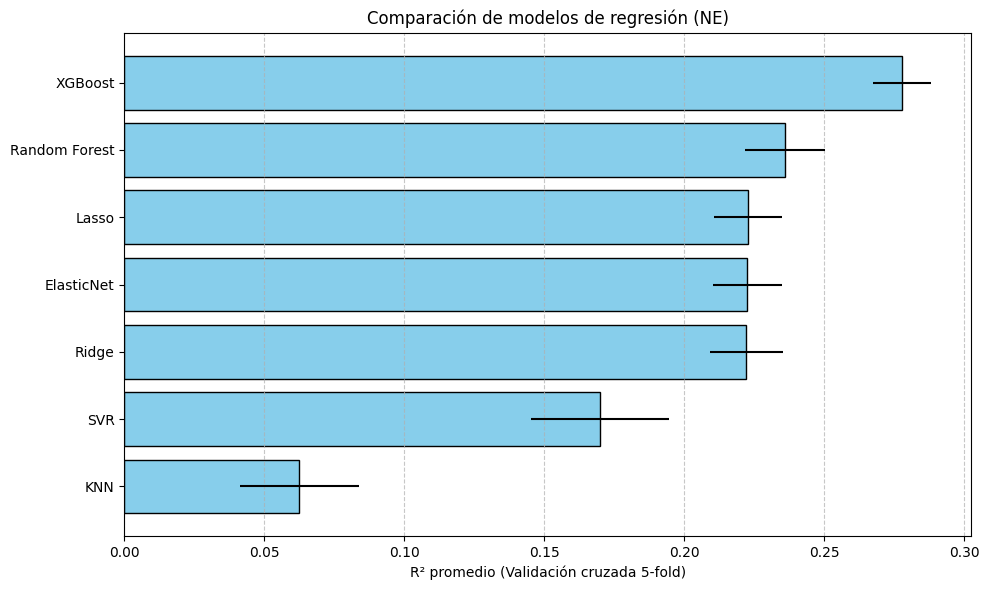

In [29]:
# ============================================================
# Visualización de resultados - Modelos de regresión (NE)
# ============================================================

# ------------------------------------------------------------
# Resultados de validación cruzada (R² medio y desviación)
# ------------------------------------------------------------
resultados_regresion = {
    'Lasso': (0.2227, 0.0122),
    'Ridge': (0.2222, 0.0131),
    'ElasticNet': (0.2226, 0.0122),
    'Random Forest': (0.2361, 0.0142),
    'SVR': (0.1699, 0.0247),
    'XGBoost': (0.2779, 0.0103),
    'KNN': (0.0625, 0.0212)
}

# ------------------------------------------------------------
# Creación del DataFrame de resultados
# ------------------------------------------------------------
df_reg = pd.DataFrame(resultados_regresion).T
df_reg.columns = ['R2_mean', 'R2_std']
df_reg = df_reg.sort_values('R2_mean', ascending=True)

# ------------------------------------------------------------
# Gráfico de barras horizontales con errores estándar
# ------------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.barh(
    df_reg.index,
    df_reg['R2_mean'],
    xerr=df_reg['R2_std'],
    color='skyblue',
    edgecolor='black'
)
plt.xlabel('R² promedio (Validación cruzada 5-fold)')
plt.title('Comparación de modelos de regresión (NE)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


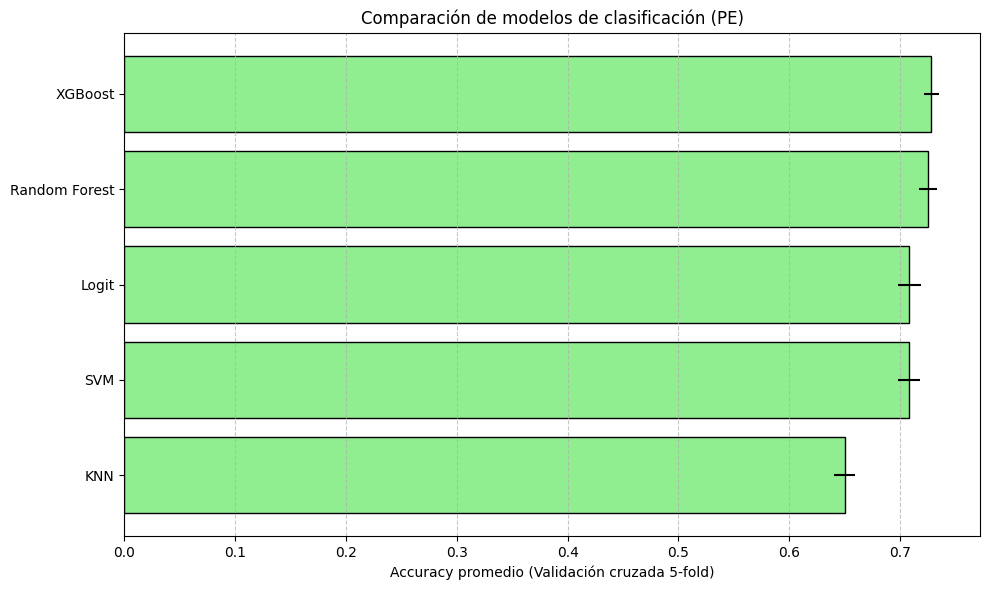

In [30]:
# ============================================================
# Visualización de resultados - Modelos de clasificación (PE)
# ============================================================

# ------------------------------------------------------------
# Resultados de validación cruzada (Accuracy medio y desviación)
# ------------------------------------------------------------
resultados_clasificacion = {
    'Logit': (0.7085, 0.0103),
    'Random Forest': (0.7249, 0.0082),
    'SVM': (0.7082, 0.0099),
    'XGBoost': (0.7283, 0.0071),
    'KNN': (0.6501, 0.0097)
}

# ------------------------------------------------------------
# Creación del DataFrame de resultados
# ------------------------------------------------------------
df_clf = pd.DataFrame(resultados_clasificacion).T
df_clf.columns = ['Acc_mean', 'Acc_std']
df_clf = df_clf.sort_values('Acc_mean', ascending=True)

# ------------------------------------------------------------
# Gráfico de barras horizontales con errores estándar
# ------------------------------------------------------------
plt.figure(figsize=(10, 6))
plt.barh(
    df_clf.index,
    df_clf['Acc_mean'],
    xerr=df_clf['Acc_std'],
    color='lightgreen',
    edgecolor='black'
)
plt.xlabel('Accuracy promedio (Validación cruzada 5-fold)')
plt.title('Comparación de modelos de clasificación (PE)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


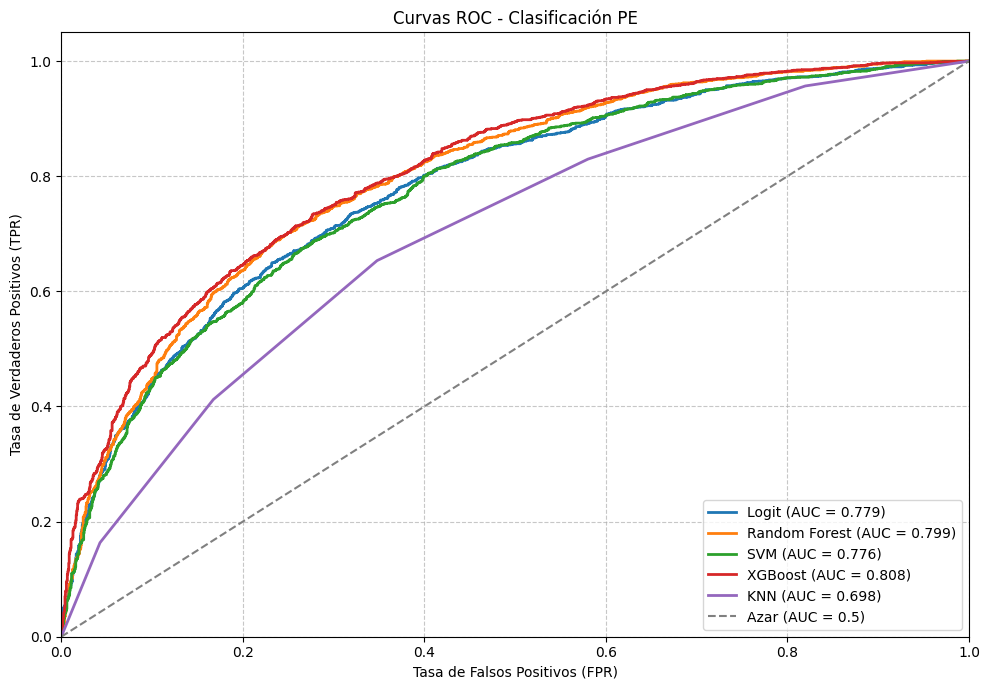

In [31]:
# ============================================================
# Curvas ROC - Modelos de clasificación (PE)
# ============================================================

# ------------------------------------------------------------
# Diccionario con modelos de clasificación
# ------------------------------------------------------------
modelos_proba = {
    'Logit': logit_model,
    'Random Forest': best_rf_clf,
    'SVM': svm_model,
    'XGBoost': xgb_clf,
    'KNN': knn_clf
}

# ------------------------------------------------------------
# Cálculo de curvas ROC y AUC
# ------------------------------------------------------------
curvas_roc = {}

for nombre, modelo in modelos_proba.items():
    try:
        # Obtener probabilidades de clase positiva
        if hasattr(modelo, "predict_proba"):
            y_proba = modelo.predict_proba(X_test)[:, 1]
        else:
            y_proba = modelo.decision_function(X_test)
            y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())  # normalización

        # Calcular curva ROC
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)

        # Guardar resultados
        curvas_roc[nombre] = (fpr, tpr, roc_auc)

    except Exception as e:
        print(f"✗ {nombre} falló en curva ROC: {e}")

# ------------------------------------------------------------
# Visualización de curvas ROC
# ------------------------------------------------------------
plt.figure(figsize=(10, 7))
for nombre, (fpr, tpr, roc_auc) in curvas_roc.items():
    plt.plot(fpr, tpr, lw=2, label=f"{nombre} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Azar (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curvas ROC - Clasificación PE")
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [32]:
# ============================================================
# Curvas Precision-Recall - Modelos de clasificación (PE)
# ============================================================

# ------------------------------------------------------------
# Cálculo de curvas PR y AUC-PR
# ------------------------------------------------------------
curvas_pr = {}

for nombre, modelo in modelos_proba.items():
    try:
        # Obtener probabilidades de clase positiva
        if hasattr(modelo, "predict_proba"):
            y_proba = modelo.predict_proba(X_test)[:, 1]
        else:
            y_proba = modelo.decision_function(X_test)
            y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())  # normalización

        # Calcular curva Precision-Recall
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        avg_precision = average_precision_score(y_test, y_proba)

        # Guardar resultados
        curvas_pr[nombre] = (recall, precision, avg_precision)

    except Exception as e:
        print(f"✗ {nombre} falló en curva PR: {e}")


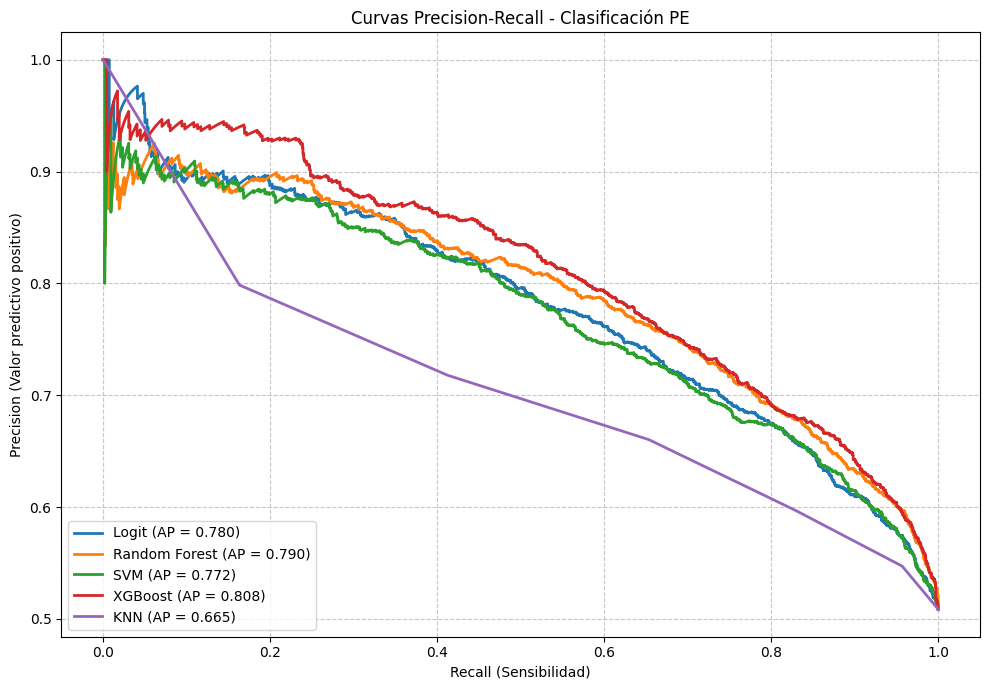

In [33]:
# ------------------------------------------------------------
# Visualización de curvas Precision-Recall
# ------------------------------------------------------------
plt.figure(figsize=(10, 7))

for nombre, (recall, precision, avg_precision) in curvas_pr.items():
    plt.plot(
        recall,
        precision,
        lw=2,
        label=f"{nombre} (AP = {avg_precision:.3f})"
    )

plt.xlabel("Recall (Sensibilidad)")
plt.ylabel("Precision (Valor predictivo positivo)")
plt.title("Curvas Precision-Recall - Clasificación PE")
plt.legend(loc="lower left")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [34]:
# ============================================================
# Umbral óptimo para clasificación - Basado en curva ROC
# ============================================================

# ------------------------------------------------------------
# Selección del modelo de referencia
# ------------------------------------------------------------
modelo_objetivo = xgb_clf  # Se puede cambiar modelo

# ------------------------------------------------------------
# Obtener probabilidades de clase positiva
# ------------------------------------------------------------
if hasattr(modelo_objetivo, "predict_proba"):
    y_proba = modelo_objetivo.predict_proba(X_test)[:, 1]
else:
    y_proba = modelo_objetivo.decision_function(X_test)
    y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())  # normalización

# ------------------------------------------------------------
# Calcular curva ROC y distancias al punto ideal (0, 1)
# ------------------------------------------------------------
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
distancias = np.sqrt((1 - tpr)**2 + fpr**2)
idx_optimo = np.argmin(distancias)
umbral_optimo = thresholds[idx_optimo]

# ------------------------------------------------------------
# Resultados
# ------------------------------------------------------------
print(f"✔️ Umbral óptimo (XGBoost): {umbral_optimo:.3f}")
print(f"- Sensibilidad (TPR): {tpr[idx_optimo]:.3f}")
print(f"- Especificidad (1 - FPR): {1 - fpr[idx_optimo]:.3f}")


✔️ Umbral óptimo (XGBoost): 0.484
- Sensibilidad (TPR): 0.733
- Especificidad (1 - FPR): 0.724


In [35]:
# ============================================================
# Evaluación del modelo con umbral óptimo
# ============================================================

# ------------------------------------------------------------
# Clasificación ajustada al nuevo umbral
# ------------------------------------------------------------
y_pred_optimo = (y_proba >= umbral_optimo).astype(int)

# ------------------------------------------------------------
# Métricas de desempeño
# ------------------------------------------------------------
print("\n=== Evaluación con umbral óptimo ===")
print("Matriz de Confusión:")
print(confusion_matrix(y_test, y_pred_optimo))

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred_optimo))



=== Evaluación con umbral óptimo ===
Matriz de Confusión:
[[1408  538]
 [ 537 1477]]

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.72      0.72      0.72      1946
           1       0.73      0.73      0.73      2014

    accuracy                           0.73      3960
   macro avg       0.73      0.73      0.73      3960
weighted avg       0.73      0.73      0.73      3960

